In [1]:
# Filtering out the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import the required Libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Notes

- There could be multiple applications from the same customer
- Amounts -> Can they be rounded off?

AMT_APPLICATION, AMT_CREDIT, AMT_GOODS_PRICE
- Goods Vs Amount loan
- Is lesser amount given than that is asked for? AMT_APPLICATION	AMT_CREDIT	
- Is more amount asked for than that is needed? AMT_APPLICATION	AMT_GOODS_PRICE
- No information on whether the applicant has paid off the previous loans
- AMT_DOWN_PAYMENT & RATE_DOWN_PAYMENT occur together

Current Application & Previous Application
- Do all clients with current application have entries in previous application?
- For each Client, number of previous applications & how many were completed.
- 1 curr_id has multiple prev_ids. Add number of prev_ids associated with this curr_id

Others
- Replace all FLAG_DOCUMENT with a single FLAG_DOCUMENT with the sum
- Correlation matrix
- No information on whether the applicant has paid off the previous loans
- Columns have empty values
- Merge 2 datasets
- How to show/hide output - o

1. Data Cleaning: 
    - Remove the irrelevant columns. 
    - Remove/impute the missing values
2. Outlier handling:
    Only detect outliers. No handling - no impute or treat
    - Univariate: ordered or unordered, or it may be a numerical variable.
        - Categorical unordered:
        - Categorical ordered
        - Numerical variable: mean, median, mode, quantiles, and box plots, 
            - continuous
            - discrete 
        - Convert numerical variables into categorical ones
    - Multivariate  
        -  Bivariate: 
            - correlation and scatter plots on numerical variables
            - numerical and categorical variables: Boxplot
            - two categorical variables: bar graph
        -  Multivariate: heat maps 
3. Standardising values
Fixing invalid values
Filter data
Data imbalance


### Table of Contents <a class="anchor" id="toc"></a>

* [Definitions](#definitions)
    * [Section 1.1](#section_1_1)
    * [Section 1.2](sSection_1_2)
        * [Section 1.2.1](#section_1_2_1)
        * [Section 1.2.2](#section_1_2_2)
        * [Section 1.2.3](#section_1_2_3)
* [Chapter 2](#chapter2)
    * [Section 2.1](#section_2_1)
    * [Section 2.2](#section_2_2)


## Problem Statement

## Definitions <a class="anchor" id="definitions"></a> [TOC](#toc)

In [3]:
def percent(val, total):
    return round(100 * val/total, 2)

def getIQR(df, col):
    Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    return Q3 - Q1

def getMinScore(df, col):
    Q1 = df[col].quantile(0.75)
    iqr = getIQR(df, col)
    return Q1 - 1.5 * iqr

def getMaxScore(df, col):
    Q3 = df[col].quantile(0.75)
    iqr = getIQR(df, col)
    return Q3 + 1.5 * iqr

In [4]:
def getColumnsStartingWith(df, prefix):
    prefixlen = len(prefix)
    return list(filter(lambda x: x[:prefixlen] == prefix, df.columns.tolist()))
    
def listColumsWithMissingData(df):
    naCols = len(df.columns[df.isna().any()])
    print(f"Columns with missing data: {naCols} {percent(naCols, len(df.columns))}%")
    [print(f"{col:30}  {df[col].isna().sum(): 7d} {percent(df[col].isna().sum(),df.shape[0])}%") for col in df.columns if df[col].isna().any() ]
    
def dropColumns(df, coldesc, cols):
    print(f"Drop {coldesc} {len(cols)} columns: Shape - before {df.shape}", end=" ")
    df.drop(columns = cols, inplace=True)
    print(f"Shape - after {df.shape}")

In [5]:
def getCategoricalValues(df):
    cat_columns = df.select_dtypes(include=['object']).columns.tolist()
    cat_columns.sort()
    print(f"Columns with categorical values {len(cat_columns)} --> {cat_columns}")
    for col in cat_columns:
        count_values = df[col].unique().shape[0]
        print(f"{col:27} : [{count_values:2}] --> {sorted((df[col].unique().tolist())) if np.NaN not in df[col].unique().tolist() else (df[col].unique().tolist())}")
        
def getNumCategoricalValues(df, ncat_columns):
    ncat_columns.sort()
    print(f"Columns with categorical values {len(ncat_columns)}")
    for col in ncat_columns:
        count_values = df[col].unique().shape[0]
        if count_values > 30:
            print(f"{col:26} : [{count_values:4}] --> {sorted(df[col].unique().tolist()[:10])}...{sorted(df[col].unique().tolist()[-10:])}") 
        else:
            print(f"{col:26} : [{count_values:4}] --> {sorted(df[col].unique().tolist())}") 

def makeDFForTarget(df, col, taretVal):
    df_ = df[df['TARGET']==taretVal][[col,'TARGET']]
    cnt = df_.shape[0]
    df_ = groupByAndCount(df_, col, skipPercent=False)
    df_.rename(columns={'Count':f'Target={taretVal}'},inplace=True)
    #print(df_)
    return df_, cnt


def makeDFForTargets(df, col):
    df_1, cnt_1 = makeDFForTarget(df, col, 1)
    df_0, cnt_0 = makeDFForTarget(df, col, 0)
    print(cnt_1, cnt_0)

    df_ = df_0.merge(df_1, how='left',on=col)
    print(df_)
    df_.set_index(col, inplace=True)
    return df_


def groupByAndCount(df, col, sort = True, skipPercent=True):
    total_rows = df.shape[0]
    df_ = df.groupby(by=col).agg({col:"count"})
    df_.rename(columns={col:'Count'}, inplace=True)
    df_.reset_index(inplace=True)
    if sort == True: df_.sort_values(by='Count', ascending=False, inplace=True)
    if not skipPercent:
        df_['%'] = round((df_['Count']/total_rows)*100,2)
    return df_
    
def groupPerTarget(df, col):
    df_1 = df[df['TARGET']==1][[col,'TARGET']]
    cnt_1 = df_1.shape[0]
    df_1 = groupByAndCount(df_1, col, sort = False)
    df_1.rename(columns={'Count':'Target=1'},inplace=True)
    #print(df_1)

    df_0 = df[df['TARGET']==0][[ col,'TARGET']]
    cnt_0 = df_0.shape[0]
    df_0 = groupByAndCount(df_0, col, sort = False)
    df_0.rename(columns={'Count':'Target=0'},inplace=True)
    #print(df_0)


    df_ = df_0.merge(df_1, how='left',on=col)
    if df_.isna().sum().sum() > 0:
        df_.fillna(0, inplace=True)
    df_['Total'] = df_['Target=0'] + df_['Target=1']
    df_['Target=0%'] = percent(df_['Target=0'], df_['Total']) 
    df_['Target=1%'] = percent(df_['Target=1'], df_['Total'])
    df_.set_index(col, inplace=True)

    #df_[['Total', 'Target=1', 'Target=0']].astype('int32')
    df_= df_[['Total', 'Target=1', 'Target=0', 'Target=1%', 'Target=0%' ]]

    print(f"df_1: {cnt_1}, df_0: {cnt_0}")
    print(df_)
    
    return df_

# -----
def groupByTargetAndCount(df, value, sort = True, skipPercent=True):
    total_rows = df.shape[0]
    df_ = df.groupby(by='TARGET').agg({'TARGET':"count"})
    df_.rename(columns={'TARGET': f'{value}_Count'}, inplace=True)
    df_.reset_index(inplace=True)
    if sort == True: df_.sort_values(by=f'{value}_Count', ascending=False, inplace=True)
    if not skipPercent:
        df_[f'{value}_%'] = round((df_[f'{value}_Count']/total_rows)*100,2)
    return df_

def makeDFForTarget1(df, col, value):
    df_ = df[df[col]==value][[col,'TARGET']]
    #print(df_)
    cnt = df_.shape[0]
    df_ = groupByTargetAndCount(df_, value, skipPercent=False)
    return df_, cnt


def makeDFForTargets1(df, col):
    df_1, cnt_1 = makeDFForTarget1(df_ca, col, 'N')
    df_0, cnt_0 = makeDFForTarget1(df_ca, col, 'Y')
    print(cnt_1, cnt_0)
    df_ = df_0.merge(df_1, how='left',on='TARGET')
    print(df_)
    df_.set_index('TARGET', inplace=True)
    df_ = df_.transpose()
    df_ = df_.loc[['Y_%', 'N_%']]
    return df_
# ---

In [6]:
def plotBar(df, title, w=10, h=10, logy=False):
    plt.figure(figsize=(w, h), dpi=80)
    ax = df.plot.bar(logy=logy) 
    # Annotate
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
    ax.set_title(title)
    plt.show()

def annotate(ax):
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

def plotScatter(df, col1, col2, title, pos=1, log=False):
    plt.subplot(1, 2, pos)
    ax = df.plot.scatter(col1, col2,figsize=(10, 6))
    if log == True: ax.set_xscale('log')
    ax.set_title(title)
    plt.show()

# TODO: annotation - add %
def compare(df, col, title, labels=[], figsize=(10, 6)):
    df_ = groupPerTarget(df, col)

    plt.figure(dpi=80) #figsize=(20, 6),dpi=80
    plt.subplot(1, 2, 1)

    ax = df_[['Target=0','Target=1']].plot.bar(ax=plt.gca(), logy=True, figsize=figsize, rot=90)
    annotate(ax)
    if labels: ax.set_xticklabels(labels=labels, rotation=45)
    ax.set_title(f"{title} Vs Target - Absolute values")

    plt.subplot(1, 2, 2)
    ax = df_[['Target=0%','Target=1%']].plot.bar(ax=plt.gca(), logy=True, figsize=figsize)
    annotate(ax)
    if labels: ax.set_xticklabels(labels=labels, rotation=45)
    ax.set_title(f"{title} Vs Target - %age values")

### Data Reading & Data Types 

#### PA data exploration - remove?

In [7]:
#Read the data in pandas
df_pa = pd.read_csv("data/previous_application.csv")

In [8]:
df_pa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1048575 non-null  int64  
 1   SK_ID_CURR                   1048575 non-null  int64  
 2   NAME_CONTRACT_TYPE           1048575 non-null  object 
 3   AMT_ANNUITY                  815566 non-null   float64
 4   AMT_APPLICATION              1048575 non-null  float64
 5   AMT_CREDIT                   1048575 non-null  float64
 6   AMT_DOWN_PAYMENT             489179 non-null   float64
 7   AMT_GOODS_PRICE              807610 non-null   float64
 8   WEEKDAY_APPR_PROCESS_START   1048575 non-null  object 
 9   HOUR_APPR_PROCESS_START      1048575 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1048575 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1048575 non-null  int64  
 12  RATE_DOWN_PAYMENT            489179 non-nu

In [9]:
PA_COLUMNS = df_pa.columns.tolist()
PA_ID_COLUMNS = ['SK_ID_PREV','SK_ID_CURR']
PA_NCAT_COLUMNS = ['NFLAG_INSURED_ON_APPROVAL', 'NFLAG_LAST_APPL_IN_DAY', 'SELLERPLACE_AREA', 'HOUR_APPR_PROCESS_START']
print(len(max(PA_COLUMNS)))
getNumCategoricalValues(df_pa, PA_NCAT_COLUMNS)

26
Columns with categorical values 4
HOUR_APPR_PROCESS_START    : [  24] --> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
NFLAG_INSURED_ON_APPROVAL  : [   3] --> [0.0, 1.0, nan]
NFLAG_LAST_APPL_IN_DAY     : [   2] --> [0, 1]
SELLERPLACE_AREA           : [2023] --> [-1, 6, 20, 35, 50, 61, 83, 130, 136, 200]...[1633, 1749, 1854, 1910, 2173, 2867, 3126, 3322, 5557, 6052]


In [10]:
getCategoricalValues(df_pa)

Columns with categorical values 16 --> ['CHANNEL_TYPE', 'CODE_REJECT_REASON', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CLIENT_TYPE', 'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PAYMENT_TYPE', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_TYPE_SUITE', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION', 'WEEKDAY_APPR_PROCESS_START']
CHANNEL_TYPE                : [ 8] --> ['AP+ (Cash loan)', 'Car dealer', 'Channel of corporate sales', 'Contact center', 'Country-wide', 'Credit and cash offices', 'Regional / Local', 'Stone']
CODE_REJECT_REASON          : [ 9] --> ['CLIENT', 'HC', 'LIMIT', 'SCO', 'SCOFR', 'SYSTEM', 'VERIF', 'XAP', 'XNA']
FLAG_LAST_APPL_PER_CONTRACT : [ 2] --> ['N', 'Y']
NAME_CASH_LOAN_PURPOSE      : [25] --> ['Building a house or an annex', 'Business development', 'Buying a garage', 'Buying a holiday home / land', 'Buying a home', 'Buying a new car', 'Buying a used car', 'Car repairs', 'Education', 'Everyday 

In [11]:
df_pa[df_pa.columns.difference(PA_ID_COLUMNS + PA_NCAT_COLUMNS)].describe()

,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,CNT_PAYMENT,DAYS_DECISION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_TERMINATION,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED
count,815566.000000,1.048575e+06,1.048575e+06,4.891790e+05,8.076100e+05,815569.000000,1.048575e+06,627867.000000,627867.000000,627867.000000,627867.000000,627867.000000,489179.000000,3721.000000,3721.000000
mean,15891.265151,1.742698e+05,1.950000e+05,6.700778e+03,2.262892e+05,15.995639,-8.820381e+02,342387.346201,13833.802031,76591.061435,33614.930898,81985.701661,0.079619,0.187177,0.774922
std,14745.557438,2.910789e+05,3.169407e+05,2.078570e+04,3.134490e+05,14.508109,7.792649e+02,88595.441587,72460.126454,149653.053854,106643.960780,153298.887247,0.107882,0.083343,0.099514
min,0.000000,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000,-2.922000e+03,-2921.000000,-2892.000000,-2889.000000,-2801.000000,-2874.000000,-0.000014,0.034781,0.373150
25%,6301.350000,1.890000e+04,2.427750e+04,0.000000e+00,5.058000e+04,6.000000,-1.303000e+03,365243.000000,-1626.000000,-1313.000000,-1241.000000,-1269.000000,0.000000,0.160716,0.715645
50%,11250.000000,7.081650e+04,8.025300e+04,1.624500e+03,1.115116e+05,12.000000,-5.830000e+02,365243.000000,-830.000000,-537.000000,-361.000000,-498.000000,0.051062,0.189122,0.835095
75%,20523.003750,1.800000e+05,2.152395e+05,7.749000e+03,2.295000e+05,24.000000,-2.810000e+02,365243.000000,-410.000000,-74.000000,128.000000,-44.000000,0.108909,0.193330,0.852537
max,418058.145000,6.905160e+06,6.905160e+06,2.150100e+06,6.905160e+06,84.000000,-2.000000e+00,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,0.989740,1.000000,1.000000


In [12]:
df_pa.loc[df_pa['NAME_PRODUCT_TYPE']!='x-sell'][['NAME_PRODUCT_TYPE','NAME_SELLER_INDUSTRY']]

,NAME_PRODUCT_TYPE,NAME_SELLER_INDUSTRY
0,XNA,Connectivity
4,walk-in,XNA
6,XNA,XNA
7,XNA,XNA
8,XNA,XNA
...,...,...
1048570,XNA,Industry
1048571,XNA,XNA
1048572,XNA,Connectivity
1048573,XNA,Connectivity


In [13]:
df_pa[['NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE','RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION']]

,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_YIELD_GROUP,PRODUCT_COMBINATION
0,POS,XNA,0.000000,0.182832,0.867336,middle,POS mobile with interest
1,Cash,x-sell,NaN,NaN,NaN,low_action,Cash X-Sell: low
2,Cash,x-sell,NaN,NaN,NaN,high,Cash X-Sell: high
3,Cash,x-sell,NaN,NaN,NaN,middle,Cash X-Sell: middle
4,Cash,walk-in,NaN,NaN,NaN,high,Cash Street: high
...,...,...,...,...,...,...,...
1048570,POS,XNA,0.108909,NaN,NaN,middle,POS other with interest
1048571,XNA,XNA,NaN,NaN,NaN,XNA,Cash
1048572,POS,XNA,0.102797,NaN,NaN,low_normal,POS mobile with interest
1048573,POS,XNA,0.208048,NaN,NaN,low_normal,POS mobile with interest


Check if there are multiple entries for each client in the previous application.

In [14]:
groupByAndCount(df_pa, 'SK_ID_PREV')

,SK_ID_PREV,Count
0,1000001,1
699055,2230833,1
699042,2230811,1
699043,2230814,1
699044,2230815,1
...,...,...
349530,1614974,1
349531,1614975,1
349532,1614977,1
349533,1614978,1


In [15]:
groupByAndCount(df_pa, 'SK_ID_CURR')


,SK_ID_CURR,Count
142103,265681,52
63263,173680,47
75369,187868,46
116034,235163,43
28387,133023,42
...,...,...
144146,268062,1
235260,374185,1
235258,374180,1
144149,268065,1


There is only one entry per client

Do all clients in current application have an entry in the previous application?

In [16]:
groupByAndCount(df_pa, 'NAME_CONTRACT_STATUS', skipPercent=False)

,NAME_CONTRACT_STATUS,Count,%
0,Approved,652486,62.23
1,Canceled,197231,18.81
2,Refused,182083,17.36
3,Unused offer,16775,1.60


In [17]:
groupByAndCount(df_pa, 'NAME_CONTRACT_TYPE', skipPercent=False)

,NAME_CONTRACT_TYPE,Count,%
0,Cash loans,465861,44.43
1,Consumer loans,461049,43.97
2,Revolving loans,121441,11.58
3,XNA,224,0.02


In [18]:
groupByAndCount(df_pa, 'NAME_CLIENT_TYPE', skipPercent=False)

,NAME_CLIENT_TYPE,Count,%
2,Repeater,771957,73.62
0,New,189990,18.12
1,Refreshed,85411,8.15
3,XNA,1217,0.12


In [19]:
df_pa['NAME_CLIENT_TYPE'].value_counts()

Repeater     771957
New          189990
Refreshed     85411
XNA            1217
Name: NAME_CLIENT_TYPE, dtype: int64

In [20]:
groupByAndCount(df_pa, 'NAME_PORTFOLIO', skipPercent=False)

,NAME_PORTFOLIO,Count,%
3,POS,436846,41.66
2,Cash,287509,27.42
4,XNA,233006,22.22
0,Cards,90935,8.67
1,Cars,279,0.03


In [21]:
groupByAndCount(df_pa, 'NAME_GOODS_CATEGORY', skipPercent=False)

,NAME_GOODS_CATEGORY,Count,%
27,XNA,593690,56.62
19,Mobile,141737,13.52
7,Consumer Electronics,77107,7.35
5,Computers,67082,6.40
2,Audio/Video,62910,6.00
11,Furniture,33931,3.24
22,Photo / Cinema Equipment,15779,1.50
6,Construction Materials,15754,1.50
4,Clothing and Accessories,14764,1.41
3,Auto Accessories,4706,0.45


In [22]:
groupByAndCount(df_pa, 'NAME_PRODUCT_TYPE', skipPercent=False)

,NAME_PRODUCT_TYPE,Count,%
0,XNA,670131,63.91
2,x-sell,284428,27.13
1,walk-in,94016,8.97


In [23]:
groupByAndCount(df_pa, 'CHANNEL_TYPE', skipPercent=False)

,CHANNEL_TYPE,Count,%
5,Credit and cash offices,451047,43.02
4,Country-wide,312690,29.82
7,Stone,134196,12.80
6,Regional / Local,68621,6.54
3,Contact center,41962,4.00
0,AP+ (Cash loan),35806,3.41
2,Channel of corporate sales,3958,0.38
1,Car dealer,295,0.03


In [24]:
groupByAndCount(df_pa, 'PRODUCT_COMBINATION', skipPercent=False)

,PRODUCT_COMBINATION,Count,%
2,Cash,178352,17.01
9,POS household with interest,166869,15.91
13,POS mobile with interest,139176,13.27
8,Cash X-Sell: middle,89806,8.56
7,Cash X-Sell: low,80873,7.71
0,Card Street,70951,6.77
11,POS industry with interest,62492,5.96
10,POS household without interest,52747,5.03
1,Card X-Sell,50490,4.82
3,Cash Street: high,37235,3.55


In [25]:
df_pa['RATE_DOWN_PAYMENT'].isna().sum() 

559396

In [26]:
df_pa['interest'] = np.NaN
df_pa['interest'].isna().sum() 

1048575

In [27]:
df_pa['interest'] = df_pa.apply(lambda x: x['RATE_DOWN_PAYMENT'] + x['RATE_INTEREST_PRIMARY'] + x['RATE_INTEREST_PRIVILEGED'], axis=1)

In [28]:
df_pa['interest'] 

0          1.050168
1               NaN
2               NaN
3               NaN
4               NaN
             ...   
1048570         NaN
1048571         NaN
1048572         NaN
1048573         NaN
1048574         NaN
Name: interest, Length: 1048575, dtype: float64

In [29]:

PRODUCT_COMBINATION_COLUMNS = ['interest', 'NAME_PORTFOLIO', 'NAME_GOODS_CATEGORY', 'NAME_PRODUCT_TYPE',   'NAME_YIELD_GROUP', 	'PRODUCT_COMBINATION']

In [30]:
df_pa[PRODUCT_COMBINATION_COLUMNS]

,interest,NAME_PORTFOLIO,NAME_GOODS_CATEGORY,NAME_PRODUCT_TYPE,NAME_YIELD_GROUP,PRODUCT_COMBINATION
0,1.050168,POS,Mobile,XNA,middle,POS mobile with interest
1,NaN,Cash,XNA,x-sell,low_action,Cash X-Sell: low
2,NaN,Cash,XNA,x-sell,high,Cash X-Sell: high
3,NaN,Cash,XNA,x-sell,middle,Cash X-Sell: middle
4,NaN,Cash,XNA,walk-in,high,Cash Street: high
...,...,...,...,...,...,...
1048570,NaN,POS,Jewelry,XNA,middle,POS other with interest
1048571,NaN,XNA,XNA,XNA,XNA,Cash
1048572,NaN,POS,Mobile,XNA,low_normal,POS mobile with interest
1048573,NaN,POS,Mobile,XNA,low_normal,POS mobile with interest


In [31]:
# TODO: Change this to .csv
df_columns = pd.read_excel("data/columns_description.xlsx")
df_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   160 non-null    int64  
 1   Table        160 non-null    object 
 2   Unnamed: 2   17 non-null     object 
 3   Category     154 non-null    object 
 4   Values       45 non-null     object 
 5   Common       8 non-null      float64
 6   Type         160 non-null    object 
 7   Remarks      23 non-null     object 
 8   Unnamed: 8   37 non-null     object 
 9   Row          160 non-null    object 
 10  Description  160 non-null    object 
 11  Special      69 non-null     object 
 12  Unnamed: 12  3 non-null      object 
dtypes: float64(1), int64(1), object(11)
memory usage: 16.4+ KB


In [32]:
PA_CONTRACT_COLUMNS = df_columns[(df_columns['Table']=='previous_application.csv') & (df_columns['Category']=='CONTRACT')]['Row'].tolist()
PA_CONTRACT_COLUMNS

['NAME_CONTRACT_TYPE',
 'AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_DOWN_PAYMENT',
 'RATE_DOWN_PAYMENT',
 'RATE_INTEREST_PRIMARY',
 'RATE_INTEREST_PRIVILEGED',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE']

In [33]:
df_pa_contract = df_pa[['SK_ID_PREV']  + PA_CONTRACT_COLUMNS]

In [34]:
df_pa_contract['AMT_APP_CRED_DIFF'] = df_pa_contract['AMT_APPLICATION'] - df_pa_contract['AMT_CREDIT']
df_pa_contract['AMT_APP_GOOD_DIFF'] = df_pa['AMT_APPLICATION'] - df_pa['AMT_GOODS_PRICE']

In [35]:
df_pa_contract['AMT_APP_CRED_DIFF'] 

0              0.0
1         -72171.0
2         -23944.5
3         -20790.0
4         -66555.0
            ...   
1048570    21096.0
1048571        0.0
1048572     1543.5
1048573     5247.0
1048574    21757.5
Name: AMT_APP_CRED_DIFF, Length: 1048575, dtype: float64

In [36]:
# Is the application amount > the goods price? Is the credit amount < application amount? 
df_pa_contract_ = df_pa_contract[(df_pa_contract['AMT_APP_GOOD_DIFF'] > 0) | (df_pa_contract['AMT_APP_CRED_DIFF'] > 0)] [['SK_ID_PREV', 'NAME_CONTRACT_TYPE', 'NAME_CONTRACT_STATUS', 'AMT_APP_CRED_DIFF', 'AMT_APP_GOOD_DIFF']]

In [37]:
df_pa_contract_.to_csv("out/temp.csv")

In [38]:
# Looks like AMT_DOWN_PAYMENT & RATE_DOWN_PAYMENT occur together. Check if there is AMT_DOWN_PAYMENT if there is no RATE_DOWN_PAYMENT? 
df_pa[ ((df_pa['RATE_DOWN_PAYMENT'] == 0) | (df_pa['RATE_DOWN_PAYMENT'].isna() == True)) & (df_pa['AMT_DOWN_PAYMENT'] > 0) ][['SK_ID_PREV', 'RATE_DOWN_PAYMENT', 'AMT_DOWN_PAYMENT']] #

,SK_ID_PREV,RATE_DOWN_PAYMENT,AMT_DOWN_PAYMENT


In [39]:
df_pa.loc[df_pa['NAME_CONTRACT_STATUS'] == 'Refused'].to_csv("out/refused.csv")

In [40]:
df_pa_curr_ids = groupByAndCount(df_pa, 'SK_ID_CURR')

In [41]:
df_pa_curr_ids

,SK_ID_CURR,Count
142103,265681,52
63263,173680,47
75369,187868,46
116034,235163,43
28387,133023,42
...,...,...
144146,268062,1
235260,374185,1
235258,374180,1
144149,268065,1


In [42]:
df_pa_curr_ids[df_pa_curr_ids['Count'] == 1].shape[0]

82414

In [43]:
df_pa_curr_ids[df_pa_curr_ids['Count'] > 1].to_csv("out/multiple_curr_id.csv")

In [44]:
curr_ids_multiple_prev_app = df_pa_curr_ids[df_pa_curr_ids['Count'] > 1]['SK_ID_CURR'].tolist()

In [45]:
curr_ids_multiple_prev_app[0:4]

[265681, 173680, 187868, 235163]

## Data Exploration - Current Application

In [46]:
# TODO: Read from file from data folder?
df_ca_orig = pd.read_csv("data/application_data.csv")

#### **CATEGORIZE AND GROUP THE COLUMNS** For convenient processing

In [47]:
CA_DEMOGRAPHIC_PERSONAL_COLS = [ 'CODE_GENDER', 'DAYS_BIRTH', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'NAME_FAMILY_STATUS', 
                            'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']
CA_DEMOGRAPHIC_PROFESSIONAL_COLS = [ 'NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']

CA_CHARACTER_COLS = getColumnsStartingWith(df_ca_orig, 'AMT_REQ_CREDIT_BUREAU_')
CA_SOCIAL_CIRCLE_COLS = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']

CA_FLAG_DOCUMENT_COLUMNS = getColumnsStartingWith(df_ca_orig, 'FLAG_DOCUMENT_')
CA_BUILDING_COLS = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
    'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
    'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE','COMMONAREA_MODE','ELEVATORS_MODE','ENTRANCES_MODE',
    'FLOORSMAX_MODE','FLOORSMIN_MODE','LANDAREA_MODE','LIVINGAPARTMENTS_MODE','LIVINGAREA_MODE','NONLIVINGAPARTMENTS_MODE','NONLIVINGAREA_MODE','APARTMENTS_MEDI',
    'BASEMENTAREA_MEDI','YEARS_BEGINEXPLUATATION_MEDI','YEARS_BUILD_MEDI','COMMONAREA_MEDI','ELEVATORS_MEDI','ENTRANCES_MEDI','FLOORSMAX_MEDI','FLOORSMIN_MEDI',
    'LANDAREA_MEDI','LIVINGAPARTMENTS_MEDI','LIVINGAREA_MEDI','NONLIVINGAPARTMENTS_MEDI','NONLIVINGAREA_MEDI','FONDKAPREMONT_MODE','HOUSETYPE_MODE',
    'TOTALAREA_MODE','WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE']

# Description of the columns/variables is not clear
CA_EXT_SOURCE_COLS = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']


# TODO: Remove 
CA_CLIENT_COLUMNS = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH', 'DAYS_EMPLOYED', ]
# df_columns[(df_columns['Table']=='application_data') & (df_columns['Category']=='CLIENT')]['Row'].tolist()
CA_APPLICATION_COLUMNS = df_columns[(df_columns['Table']=='application_data') & (df_columns['Category']=='APPLICATION')]['Row'].tolist()
CA_BUILDING_COLUMNS = df_columns[(df_columns['Table']=='application_data') & (df_columns['Category']=='BUILDING')]['Row'].tolist()

PA_DATE_COLS = ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']

#### Missing value handling

In [48]:
print("Current Application - Columns with missing vaules")
listColumsWithMissingData(df_ca_orig)

Current Application - Columns with missing vaules
Columns with missing data: 67 54.92%
AMT_ANNUITY                          12 0.0%
AMT_GOODS_PRICE                     278 0.09%
NAME_TYPE_SUITE                    1292 0.42%
OWN_CAR_AGE                      202929 65.99%
OCCUPATION_TYPE                   96391 31.35%
CNT_FAM_MEMBERS                       2 0.0%
EXT_SOURCE_1                     173378 56.38%
EXT_SOURCE_2                        660 0.21%
EXT_SOURCE_3                      60965 19.83%
APARTMENTS_AVG                   156061 50.75%
BASEMENTAREA_AVG                 179943 58.52%
YEARS_BEGINEXPLUATATION_AVG      150007 48.78%
YEARS_BUILD_AVG                  204488 66.5%
COMMONAREA_AVG                   214865 69.87%
ELEVATORS_AVG                    163891 53.3%
ENTRANCES_AVG                    154828 50.35%
FLOORSMAX_AVG                    153020 49.76%
FLOORSMIN_AVG                    208642 67.85%
LANDAREA_AVG                     182590 59.38%
LIVINGAPARTMENTS_AVG         

#### Remove following columns
| Ccolumns | Reason | 
|---|---|
| Building data columns | More than 50% data missing |
| OWN_CAR_AGE | More than 50% data missing |
| EXT_SOURCE_* columns | Meaning of these columns is not clear |
| DAYS_LAST_PHONE_CHANGE | Not using this column for analysis |
| NAME_TYPE_SUITE | |

 
- Remove rows where some data is missing - DAYS_LAST_PHONE_CHANGE
- There are no rows with TARGET variable not filled. So nothing to drop.

In [49]:
dropColumns(df_ca_orig, "Building data", CA_BUILDING_COLS)
dropColumns(df_ca_orig, "OWN_CAR_AGE", 'OWN_CAR_AGE')
dropColumns(df_ca_orig, "EXT_SOURCE_*", CA_EXT_SOURCE_COLS)
dropColumns(df_ca_orig, "DAYS_LAST_PHONE_CHANGE", 'DAYS_LAST_PHONE_CHANGE')

Drop Building data 47 columns: Shape - before (307511, 122) Shape - after (307511, 75)
Drop OWN_CAR_AGE 11 columns: Shape - before (307511, 75) Shape - after (307511, 74)
Drop EXT_SOURCE_* 3 columns: Shape - before (307511, 74) Shape - after (307511, 71)
Drop DAYS_LAST_PHONE_CHANGE 22 columns: Shape - before (307511, 71) Shape - after (307511, 70)


In [50]:
print("Current Application - Columns with missing vaules")
listColumsWithMissingData(df_ca_orig)

Current Application - Columns with missing vaules
Columns with missing data: 15 21.43%
AMT_ANNUITY                          12 0.0%
AMT_GOODS_PRICE                     278 0.09%
NAME_TYPE_SUITE                    1292 0.42%
OCCUPATION_TYPE                   96391 31.35%
CNT_FAM_MEMBERS                       2 0.0%
OBS_30_CNT_SOCIAL_CIRCLE           1021 0.33%
DEF_30_CNT_SOCIAL_CIRCLE           1021 0.33%
OBS_60_CNT_SOCIAL_CIRCLE           1021 0.33%
DEF_60_CNT_SOCIAL_CIRCLE           1021 0.33%
AMT_REQ_CREDIT_BUREAU_HOUR        41519 13.5%
AMT_REQ_CREDIT_BUREAU_DAY         41519 13.5%
AMT_REQ_CREDIT_BUREAU_WEEK        41519 13.5%
AMT_REQ_CREDIT_BUREAU_MON         41519 13.5%
AMT_REQ_CREDIT_BUREAU_QRT         41519 13.5%
AMT_REQ_CREDIT_BUREAU_YEAR        41519 13.5%


TODO: Impute the missing values

In [51]:
df_ca = df_ca_orig.copy(deep=True)
print(df_ca.shape)

(307511, 70)


Demographic - PERSONAL
Demographic - 
Character - Credit Worthiness
- Calls to Credit Bureau
- Credit history - How many previous applications were rejected?
- Social Circle
- DAYS_*
Capacity
- DEBT_TO_INCOME
- Income
- Income, Credit, Goods
Capital
- Downpayment size
- Car, Realty


### 1. Demographic - PERSONAL

| COLUMN(S) | | | 
|---|---|---|
| CODE_GENDER | Categorical |  | 
| AGE | Numerical continuous |  | 
| CNT_CHILDREN | Numerical discrete |  | 
| CNT_FAM_MEMBERS | Numerical discrete |  | 
| NAME_FAMILY_STATUS | Categorical |  | 
| HOUSING_TYPE | Categorical |  | 
| REGION_POPULATION_RELATIVE |  |  |
| REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY | Categorical  |  | 

In [52]:
df_ca_demo_per = df_ca[CA_DEMOGRAPHIC_PERSONAL_COLS + ['SK_ID_CURR', 'TARGET']]
print("Shape:",df_ca_demo_per.shape)
print("Numerical values - describe:\n"); print(df_ca_demo_per.describe())
listColumsWithMissingData(df_ca_demo_per)

Shape: (307511, 11)
Numerical values - describe:

          DAYS_BIRTH   CNT_CHILDREN  CNT_FAM_MEMBERS  \
count  307511.000000  307511.000000    307509.000000   
mean   -16036.995067       0.417052         2.152665   
std      4363.988632       0.722121         0.910682   
min    -25229.000000       0.000000         1.000000   
25%    -19682.000000       0.000000         2.000000   
50%    -15750.000000       0.000000         2.000000   
75%    -12413.000000       1.000000         3.000000   
max     -7489.000000      19.000000        20.000000   

       REGION_POPULATION_RELATIVE  REGION_RATING_CLIENT  \
count               307511.000000         307511.000000   
mean                     0.020868              2.052463   
std                      0.013831              0.509034   
min                      0.000290              1.000000   
25%                      0.010006              2.000000   
50%                      0.018850              2.000000   
75%                      0.02866

Missing values handling: CNT_FAM_MEMBERS has 2

In [53]:
print(df_ca_demo_per['CNT_FAM_MEMBERS'].mean(), df_ca_demo_per['CNT_FAM_MEMBERS'].median())

2.152665450442101 2.0


In [54]:
df_ca_demo_per['CNT_FAM_MEMBERS'] = df_ca_demo_per['CNT_FAM_MEMBERS'].fillna(df_ca_demo_per['CNT_FAM_MEMBERS'].median())

In [55]:
listColumsWithMissingData(df_ca_demo_per)

Columns with missing data: 0 0.0%


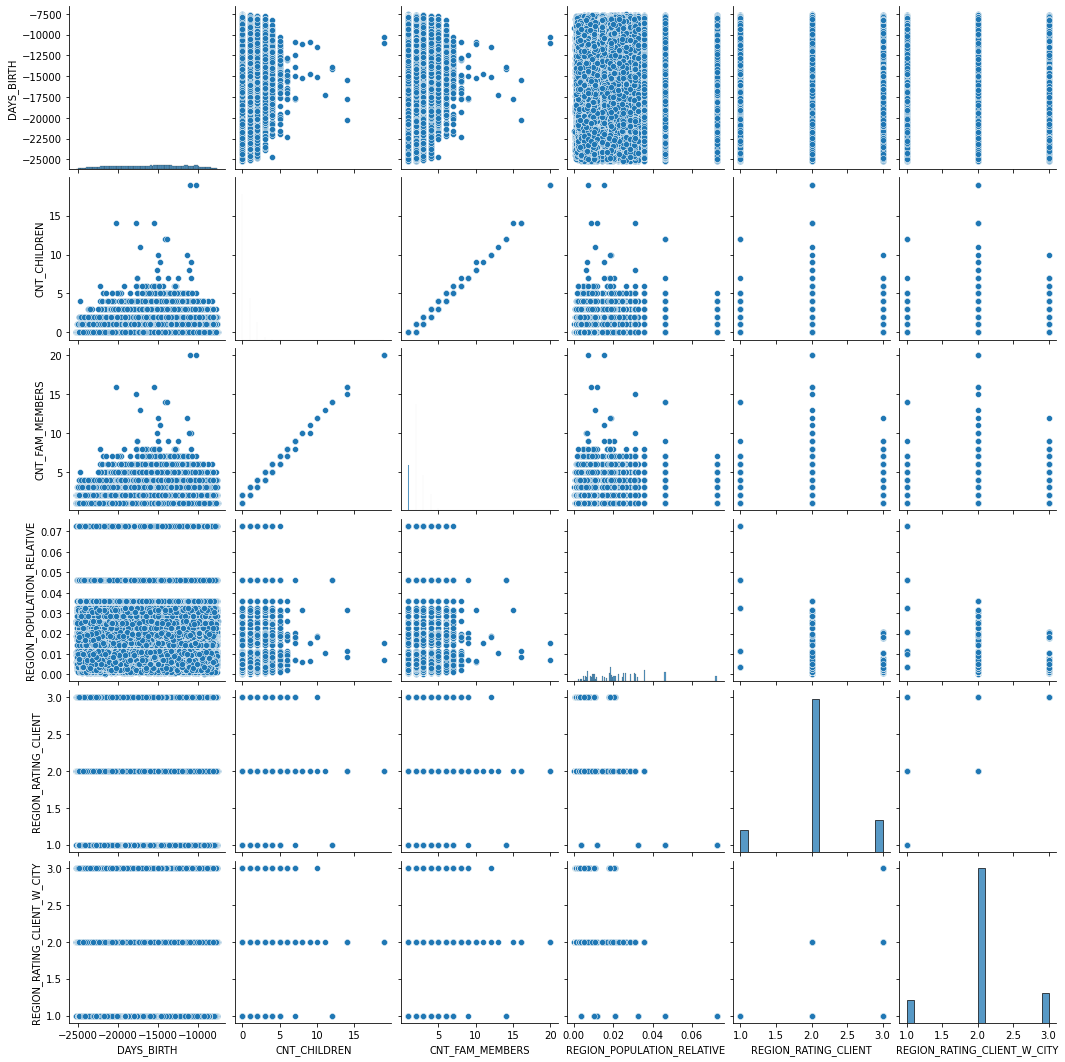

In [213]:
sns.pairplot(data=df_ca_demo_per[CA_DEMOGRAPHIC_PERSONAL_COLS])

- CNT_CHILDREN & CNT_FAM_MEMBERS are correlated

df_1: 24825, df_0: 282686
                Total  Target=1  Target=0  Target=1%  Target=0%
CODE_GENDER                                                    
F            202448.0   14170.0    188278       7.00      93.00
M            105059.0   10655.0     94404      10.14      89.86
XNA               4.0       0.0         4       0.00     100.00
df_1: 24825, df_0: 282686
                         Total  Target=1  Target=0  Target=1%  Target=0%
NAME_FAMILY_STATUS                                                      
Civil marriage         29775.0    2961.0     26814       9.94      90.06
Married               196432.0   14850.0    181582       7.56      92.44
Separated              19770.0    1620.0     18150       8.19      91.81
Single / not married   45444.0    4457.0     40987       9.81      90.19
Unknown                    2.0       0.0         2       0.00     100.00
Widow                  16088.0     937.0     15151       5.82      94.18
df_1: 24825, df_0: 282686
                  

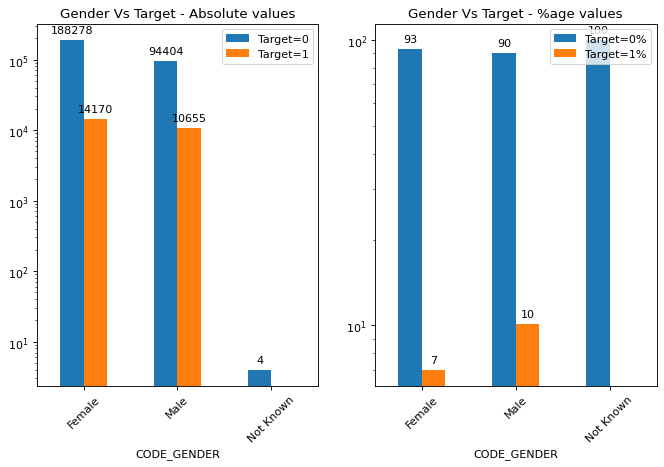

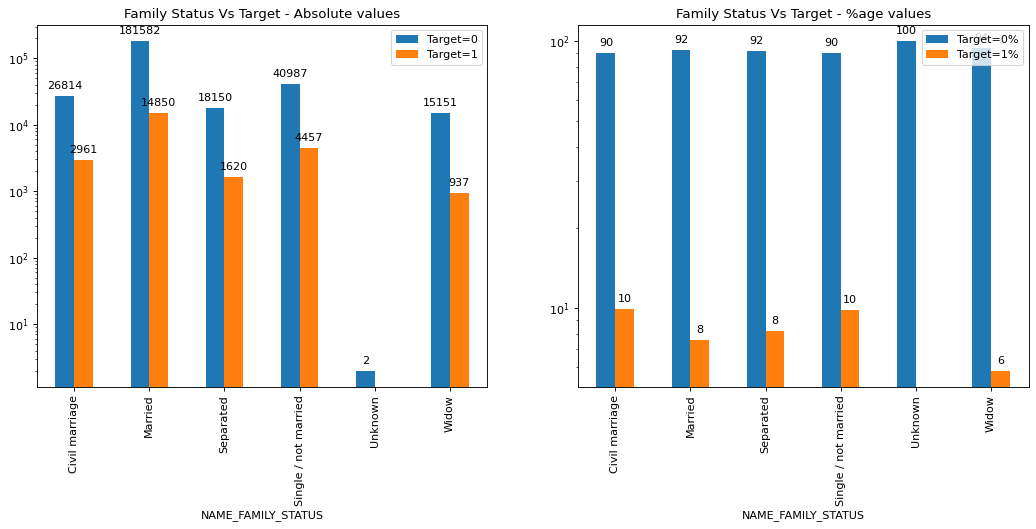

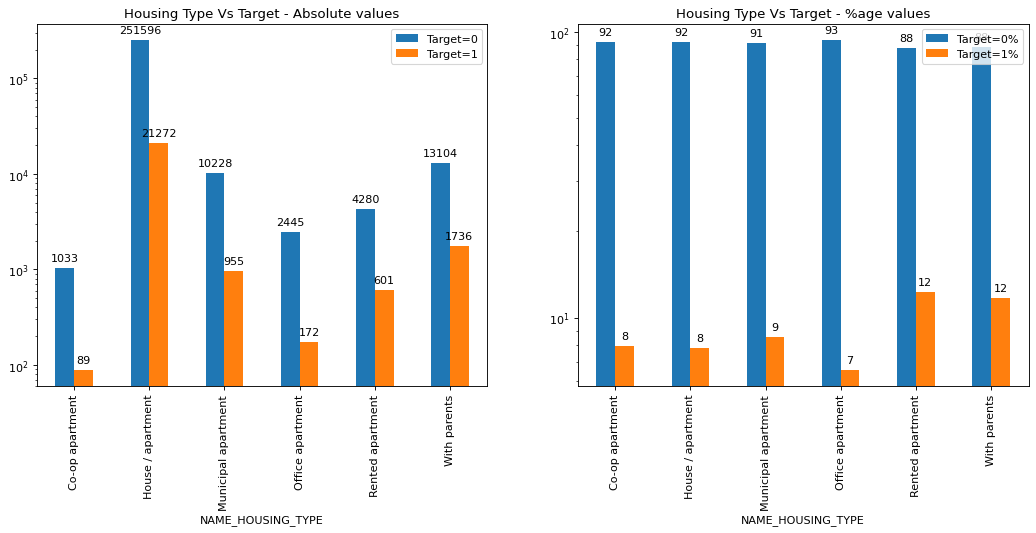

In [57]:
compare(df_ca_demo_per, 'CODE_GENDER', 'Gender', labels=['Female', 'Male', 'Not Known'])
compare(df_ca_demo_per, 'NAME_FAMILY_STATUS', 'Family Status', figsize=(16, 6)) 
compare(df_ca_demo_per, 'NAME_HOUSING_TYPE', 'Housing Type', figsize=(16, 6)) 

# TODO: 
# NAME_FAMILY_STATUS - Unknown: What should be done? Convert NaNs to 0

In [58]:
# DAYS_BIRTH 
# DAYS_BIRTH is a realative value to the application. Convert it to age.
df_ca_demo_per['AGE'] = (df_ca_demo_per['DAYS_BIRTH']/365)*(-1)

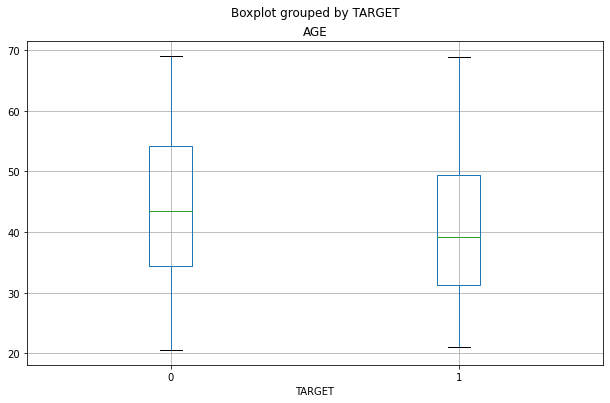

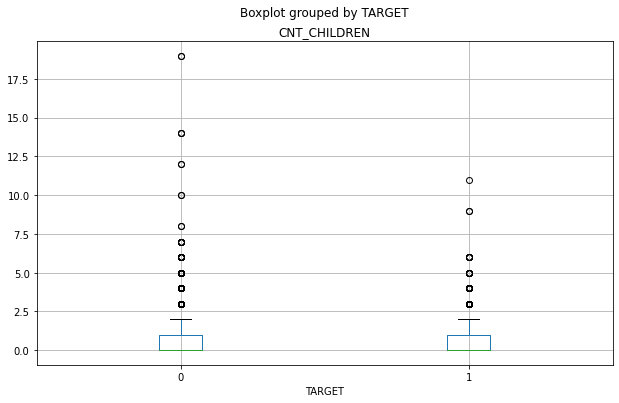

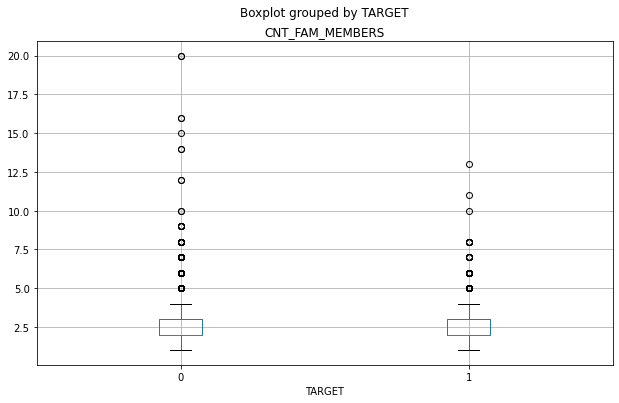

In [59]:
# Check for outliers
for col in ['AGE', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS']: 
    df_ca_demo_per.boxplot(column=col, by='TARGET', figsize = (10, 6))

It would make sense to group the ages into more maangeable groups

In [60]:
df_ca_demo_per['AGE'] = pd.cut(df_ca_demo_per['AGE'], [20, 30, 40, 50, 60, 70], labels=['20-30', '30-40', '40-50', '50-60', '60-70'])

df_1: 24825, df_0: 282686
       Total  Target=1  Target=0  Target=1%  Target=0%
AGE                                                   
20-30  45021      5158     39863      11.46      88.54
30-40  82308      7888     74420       9.58      90.42
40-50  76541      5856     70685       7.65      92.35
50-60  68062      4172     63890       6.13      93.87
60-70  35579      1751     33828       4.92      95.08
df_1: 24825, df_0: 282686
                 Total  Target=1  Target=0  Target=1%  Target=0%
CNT_CHILDREN                                                    
0             215371.0   16609.0    198762       7.71      92.29
1              61119.0    5454.0     55665       8.92      91.08
2              26749.0    2333.0     24416       8.72      91.28
3               3717.0     358.0      3359       9.63      90.37
4                429.0      55.0       374      12.82      87.18
5                 84.0       7.0        77       8.33      91.67
6                 21.0       6.0        15 

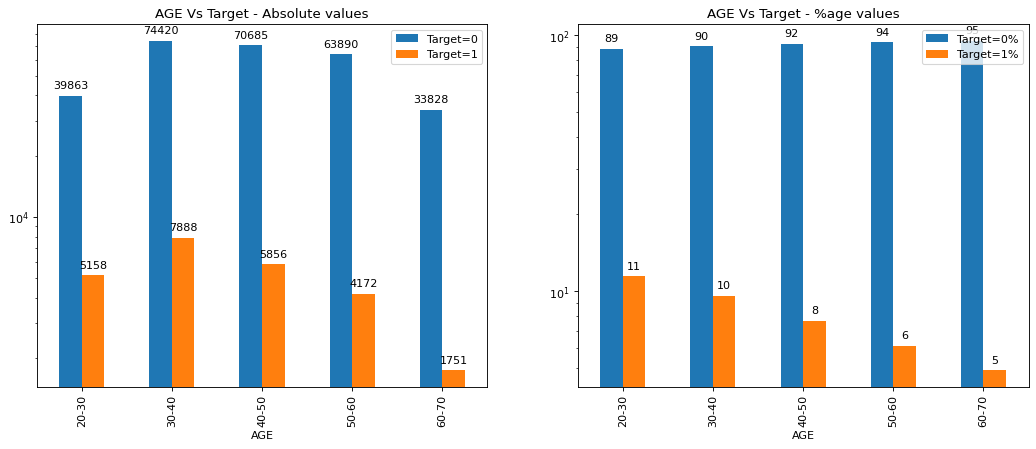

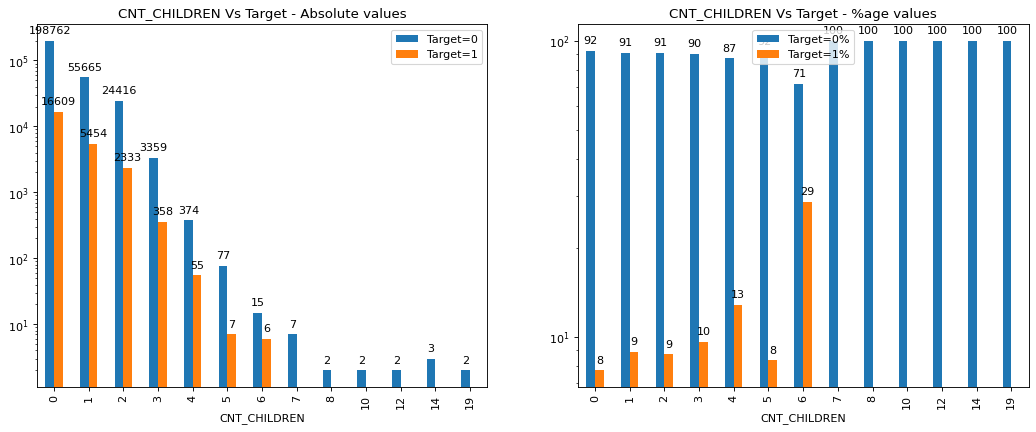

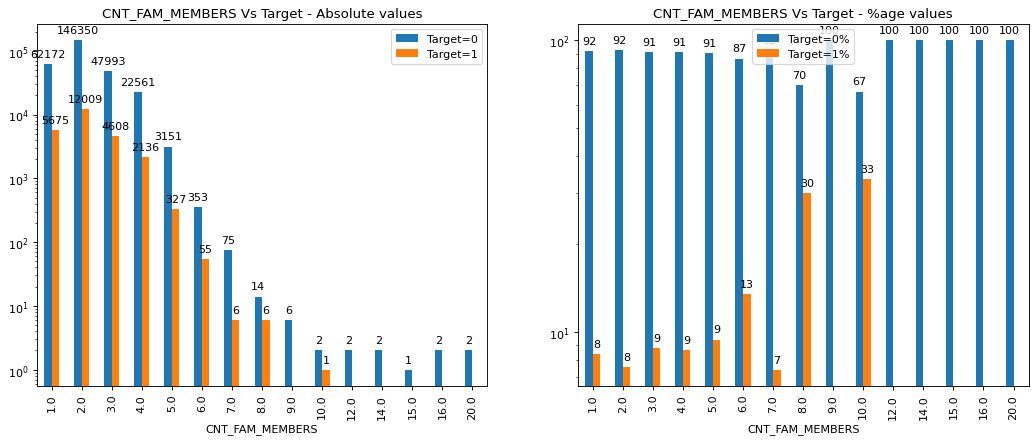

In [61]:
for col in ['AGE', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS']:
    compare(df_ca_demo_per, col, col, figsize=(16, 6)) 

In [62]:
print(df_ca_demo_per[['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']].info())
print("REGION_RATING_CLIENT != REGION_RATING_CLIENT_W_CITY =", df_ca_demo_per.loc[df_ca_demo_per['REGION_RATING_CLIENT'] != df_ca_demo_per['REGION_RATING_CLIENT_W_CITY']].shape[0])
print("REGION_RATING_CLIENT  > REGION_RATING_CLIENT_W_CITY =", df_ca_demo_per.loc[df_ca_demo_per['REGION_RATING_CLIENT'] > df_ca_demo_per['REGION_RATING_CLIENT_W_CITY']].shape[0])
print("REGION_RATING_CLIENT  < REGION_RATING_CLIENT_W_CITY =", df_ca_demo_per.loc[df_ca_demo_per['REGION_RATING_CLIENT'] < df_ca_demo_per['REGION_RATING_CLIENT_W_CITY']].shape[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 2 columns):
 #   Column                       Non-Null Count   Dtype
---  ------                       --------------   -----
 0   REGION_RATING_CLIENT         307511 non-null  int64
 1   REGION_RATING_CLIENT_W_CITY  307511 non-null  int64
dtypes: int64(2)
memory usage: 4.7 MB
None
REGION_RATING_CLIENT != REGION_RATING_CLIENT_W_CITY = 5718
REGION_RATING_CLIENT  > REGION_RATING_CLIENT_W_CITY = 5718
REGION_RATING_CLIENT  < REGION_RATING_CLIENT_W_CITY = 0


Both REGION_RATING_CLIENT and REGION_RATING_CLIENT_W_CITY indicate a similar trait. So only one can be considered. REGION_RATING_CLIENT_W_CITY ratings >= REGION_RATING_CLIENT. So let's drop REGION_RATING_CLIENT and go only with REGION_RATING_CLIENT_W_CITY

In [63]:
# We need not drop the column. Just don't consider it
# dropColumns(df_ca_demo_per, ['REGION_RATING_CLIENT'])

REGION_RATING_CLIENT_W_CITY: ['2', '1', '3']
df_1: 24825, df_0: 282686
                              Total  Target=1  Target=0  Target=1%  Target=0%
REGION_RATING_CLIENT_W_CITY                                                  
1                             32197      1552     30645       4.82      95.18
2                            226984     17907    209077       7.89      92.11
3                             48330      5366     42964      11.10      88.90


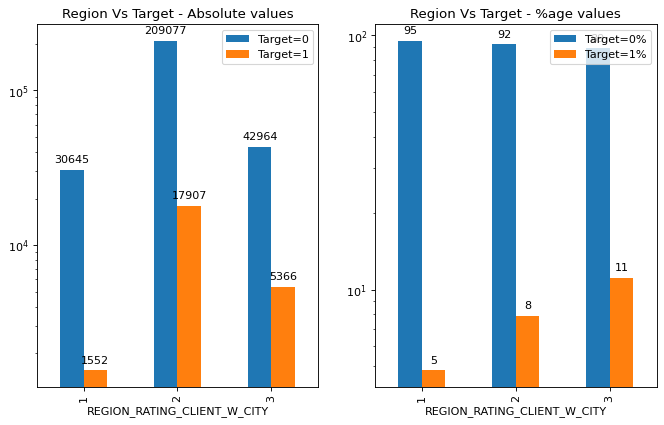

In [64]:
df_ca['REGION_RATING_CLIENT_W_CITY'] = df_ca['REGION_RATING_CLIENT'].apply(lambda x: str(x))
print('REGION_RATING_CLIENT_W_CITY:',df_ca['REGION_RATING_CLIENT_W_CITY'].unique().tolist())
compare(df_ca, 'REGION_RATING_CLIENT_W_CITY', 'Region')

#### **OBSERVATIONS**
                            
| COLUMN(S) | Missing Values? | Outliers? | Observation | Difficulties in paying | No difficulties in paying | 
|---|---|---|---|---|---|
| CODE_GENDER | None | None | More percentage of male clients have difficulties in paying off | Male Clients | Female clients|
| AGE | None | None | With increase in age, the ability to pay increases. | Younger Clients | Older clients|
| CNT_CHILDREN | None | > 6 till 19 | With increase in number of kids, the ability to pay decreases.| More children | Less children |
| CNT_FAM_MEMBERS | None | > 8 till 20 | With increase in number of family members, the ability to pay decreases | Larger family size | Smaller family size |
| NAME_FAMILY_STATUS |  |  | |  |  |
| HOUSING_TYPE | None | None | Clients in Rented apartment or staying at parents house have difficulties in paying off |  | |
| REGION_POPULATION_RELATIVE |  |  | |  |  |
| REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY | None | None | Higher the region, the clients find it more difficult to pay. Clients from regions 3 have difficulty in paying off | Higher Region category | Lower Region category |


- TODO: Look at rows that have invalid data.

### 2. Demographic - PROFESSIONAL

In [65]:
df_ca_demo_pro = df_ca[CA_DEMOGRAPHIC_PROFESSIONAL_COLS + ['SK_ID_CURR', 'TARGET']]
print("Shape:",df_ca_demo_pro.shape)
print(df_ca_demo_pro.info())
print("Numerical values - describe:\n"); print(df_ca_demo_pro.describe())
listColumsWithMissingData(df_ca_demo_pro)

Shape: (307511, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   NAME_EDUCATION_TYPE  307511 non-null  object
 1   NAME_INCOME_TYPE     307511 non-null  object
 2   OCCUPATION_TYPE      211120 non-null  object
 3   ORGANIZATION_TYPE    307511 non-null  object
 4   SK_ID_CURR           307511 non-null  int64 
 5   TARGET               307511 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 14.1+ MB
None
Numerical values - describe:

          SK_ID_CURR         TARGET
count  307511.000000  307511.000000
mean   278180.518577       0.080729
std    102790.175348       0.272419
min    100002.000000       0.000000
25%    189145.500000       0.000000
50%    278202.000000       0.000000
75%    367142.500000       0.000000
max    456255.000000       1.000000
Columns with missing data: 1 16.67%
OCCUPATION_TYPE          

| COLUMN(S) | | | 
|---|---|---|
| NAME_EDUCATION_TYPE | Categorical |  | 
| NAME_INCOME_TYPE | Categorical |  |  
| OCCUPATION_TYPE | Categorical |  | 
| ORGANIZATION_TYPE | Categorical |  | 

In [66]:
def groupPerTargetLimited(df, col):
    df_1 = df[df['TARGET']==1][[col,'TARGET']]
    cnt_1 = df_1.shape[0]
    df_1 = groupByAndCount(df_1, col, sort = False)
    df_1.rename(columns={'Count':'Target=1'},inplace=True)
    #print(df_1)

    df_0 = df[df['TARGET']==0][[ col,'TARGET']]
    cnt_0 = df_0.shape[0]
    df_0 = groupByAndCount(df_0, col, sort = False)
    df_0.rename(columns={'Count':'Target=0'},inplace=True)
    #print(df_0)


    df_ = df_0.merge(df_1, how='left',on=col)
    df_['Total'] = df_['Target=0'] + df_['Target=1']
    df_['Target=0%'] = percent(df_['Target=0'], df_['Total']) 
    df_['Target=1%'] = percent(df_['Target=1'], df_['Total'])
    df_.set_index(col, inplace=True)

    #df_[['Total', 'Target=1', 'Target=0']].astype('int32')
    df_= df_[['Total', 'Target=1', 'Target=0', 'Target=1%', 'Target=0%' ]]

    df_.sort_values(by='Target=1%', ascending=False, inplace=True)
    df_ = df_[df_['Total'] > 1000]

    #print(f"df_1: {cnt_1}, df_0: {cnt_0}")
    #print(df_)
    
    return df_

def compareLimited(df, col, title, labels=[], figsize=(10, 6)):
    df_ = groupPerTargetLimited(df, col)

    plt.figure(dpi=80) #figsize=(20, 6),dpi=80
    plt.subplot(1, 2, 1)

    ax = df_[['Target=0','Target=1']].plot.bar(ax=plt.gca(), logy=True, figsize=figsize, rot=90)
    annotate(ax)
    if labels: ax.set_xticklabels(labels=labels, rotation=45)
    ax.set_title(f"{title} Vs Target - Absolute values")

    plt.subplot(1, 2, 2)
    ax = df_[['Target=0%','Target=1%']].plot.bar(ax=plt.gca(), logy=True, figsize=figsize)
    annotate(ax)
    if labels: ax.set_xticklabels(labels=labels, rotation=45)
    ax.set_title(f"{title} Vs Target - %age values")

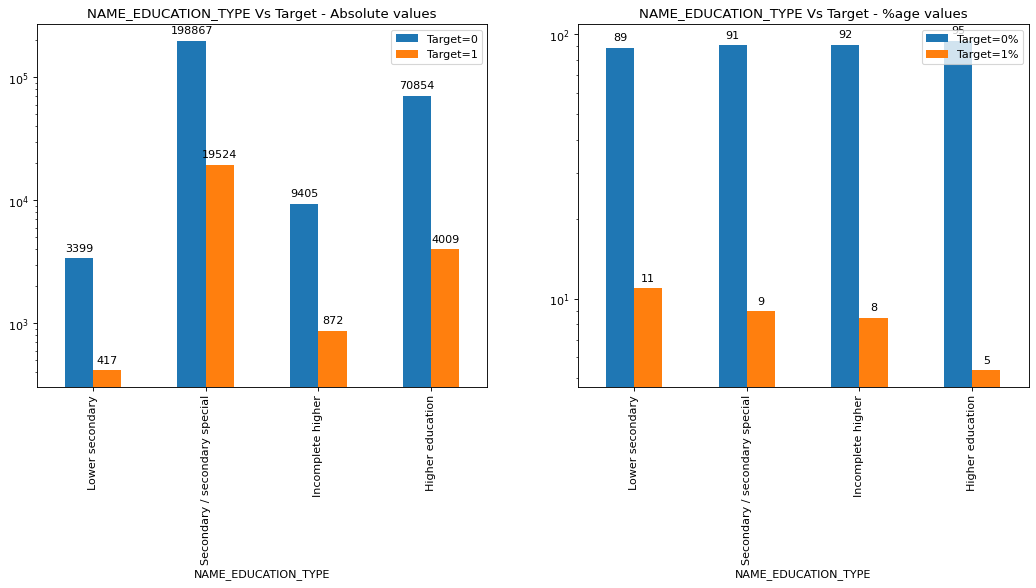

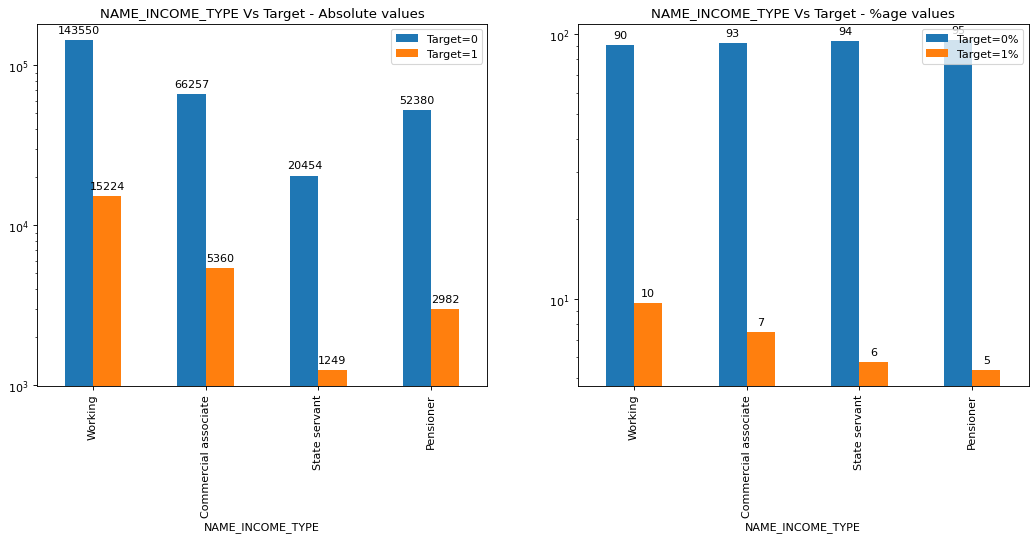

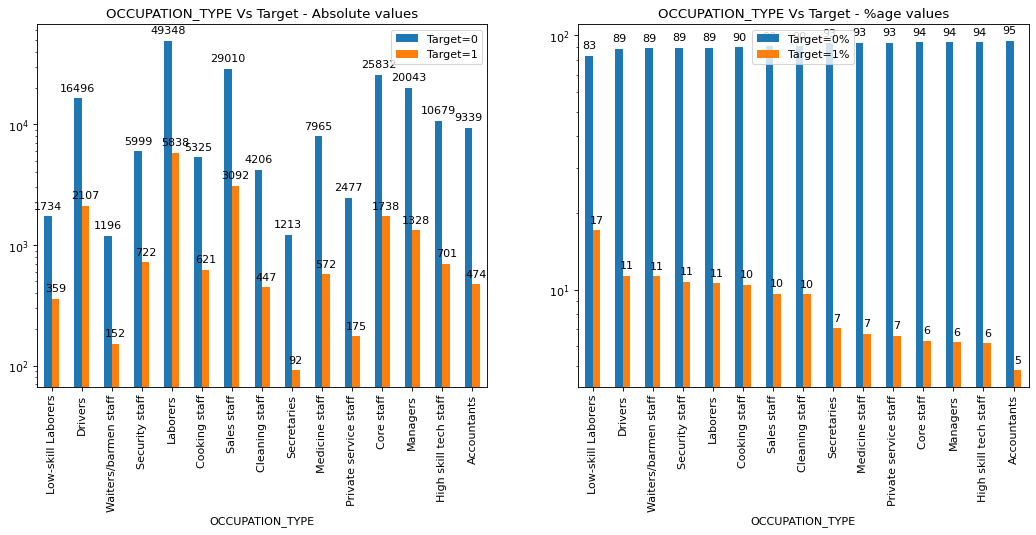

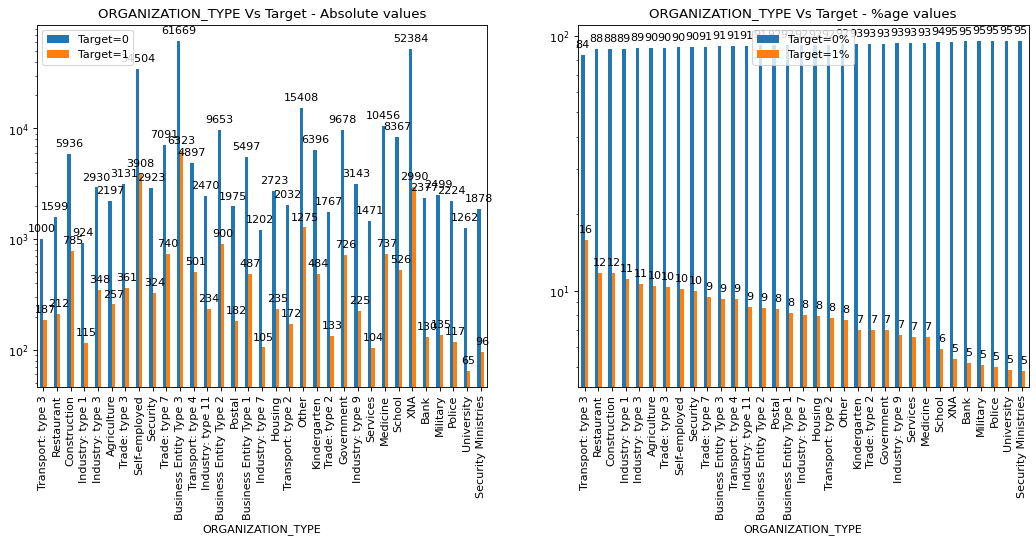

In [67]:
for col in CA_DEMOGRAPHIC_PROFESSIONAL_COLS:
    df_ = groupPerTargetLimited(df_ca_demo_pro, col)
    #print(getMinScore(df_, 'Total'))
    #print(df_['Total'].quantile([0,0.25,0.5,0.75,1]))
    compareLimited(df_ca_demo_pro,col, col,figsize=(16, 6))

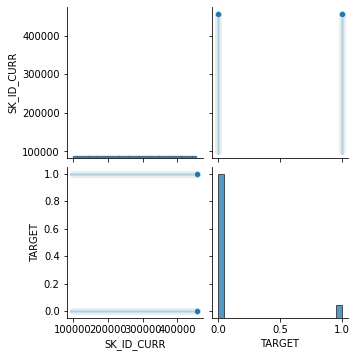

In [68]:
sns.pairplot(data=df_ca_demo_pro)

#### **OBSERVATIONS**
| COLUMN(S) | Missing Values? | Outliers? | Observation | Difficulties in paying | No difficulties in paying | 
|---|---|---|---|---|---|
| NAME_EDUCATION_TYPE | None | None | With increase in education, the ability to pay increases. | Clients with lesser education | Clients with higher education |
| NAME_INCOME_TYPE | None | None | None | Working Type | Pensioner, State Servant |
| OCCUPATION_TYPE | 31% | None | None | Lower skill labourers | Accountants |
| ORGANIZATION_TYPE | None | None | None | Transport Type 3 | Bank |

### 3. Character - Credit Worthiness
- Calls to Credit Bureau
- Credit history - How many previous applications were rejected?
- Social Circle

#### 3.1 Credit history

credit history: a borrower's reputation or track record for repaying debts

In [69]:
df_pa = pd.read_csv("data/previous_application.csv")

In [70]:
df_pa.groupby(by='SK_ID_CURR').agg({'SK_ID_PREV':'count'})

,SK_ID_PREV
SK_ID_CURR,
100001,1
100002,1
100003,2
100004,1
100006,4
...,...
456251,1
456252,1
456253,1


In [71]:
# Get the application and corresponding status
# TODO: Add Total Prev Apps column
df_pa_ca_status = df_pa.pivot_table(index='SK_ID_CURR', values=['SK_ID_PREV'],columns=['NAME_CONTRACT_STATUS'], aggfunc=['count'],fill_value=0) 
df_pa_ca_status.columns = df_pa_ca_status.columns.droplevel()
df_pa_ca_status.columns = df_pa_ca_status.columns.droplevel()
df_pa_ca_status

NAME_CONTRACT_STATUS,Approved,Canceled,Refused,Unused offer
SK_ID_CURR,,,,
100001,1,0,0,0
100002,1,0,0,0
100003,2,0,0,0
100004,1,0,0,0
100006,3,1,0,0
...,...,...,...,...
456251,1,0,0,0
456252,1,0,0,0
456253,1,0,0,0


In [72]:
df_pa_ca_counts = df_pa.pivot_table(index='SK_ID_CURR', values=['SK_ID_PREV'], aggfunc=['count'],fill_value=0) 
df_pa_ca_counts.columns = df_pa_ca_counts.columns.droplevel()
df_pa_ca_counts.rename(columns={'SK_ID_PREV':'Total Prev Apps'}, inplace=True)
df_pa_ca_counts

,Total Prev Apps
SK_ID_CURR,
100001,1
100002,1
100003,2
100004,1
100006,4
...,...
456251,1
456252,1
456253,1


In [73]:
df_pa_ca = df_pa_ca_counts.merge(df_pa_ca_status, how='inner', on='SK_ID_CURR')
df_pa_ca.reset_index(inplace=True)
df_pa_ca

,SK_ID_CURR,Total Prev Apps,Approved,Canceled,Refused,Unused offer
0,100001,1,1,0,0,0
1,100002,1,1,0,0,0
2,100003,2,2,0,0,0
3,100004,1,1,0,0,0
4,100006,4,3,1,0,0
...,...,...,...,...,...,...
305823,456251,1,1,0,0,0
305824,456252,1,1,0,0,0
305825,456253,1,1,0,0,0
305826,456254,2,2,0,0,0


In [74]:
pa_ids = df_pa_ca['SK_ID_CURR'].tolist(); print(len(pa_ids))

305828


In [75]:
df_ca.shape[0]

307511

In [76]:
df_ca[df_ca['SK_ID_CURR'].isin(pa_ids)]['SK_ID_CURR'].shape[0]

262331

In [77]:
df_ca[~df_ca['SK_ID_CURR'].isin(pa_ids)]['SK_ID_CURR'].shape[0]

45180

In [78]:
ca_ids_wo_pa_ids = df_ca[~df_ca['SK_ID_CURR'].isin(pa_ids)]['SK_ID_CURR']

In [79]:
df_pa_ca_1 = df_ca.merge(df_pa_ca, how='left', on='SK_ID_CURR')
print("Before", df_pa_ca_1.isna().sum())
df_pa_ca_1[['Total Prev Apps','Approved', 'Canceled',	'Refused',	'Unused offer']] = df_pa_ca_1[['Total Prev Apps','Approved',	'Canceled',	'Refused',	'Unused offer']].fillna(0)
print("After", df_pa_ca_1.isna().sum())
#df_pa_ca.reset_index(inplace=True)
df_pa_ca_1[['SK_ID_CURR','TARGET','Total Prev Apps','Approved',	'Canceled',	'Refused',	'Unused offer']]

Before SK_ID_CURR                0
TARGET                    0
NAME_CONTRACT_TYPE        0
CODE_GENDER               0
FLAG_OWN_CAR              0
                      ...  
Total Prev Apps       45180
Approved              45180
Canceled              45180
Refused               45180
Unused offer          45180
Length: 75, dtype: int64
After SK_ID_CURR            0
TARGET                0
NAME_CONTRACT_TYPE    0
CODE_GENDER           0
FLAG_OWN_CAR          0
                     ..
Total Prev Apps       0
Approved              0
Canceled              0
Refused               0
Unused offer          0
Length: 75, dtype: int64


,SK_ID_CURR,TARGET,Total Prev Apps,Approved,Canceled,Refused,Unused offer
0,100002,1,1.0,1.0,0.0,0.0,0.0
1,100003,0,2.0,2.0,0.0,0.0,0.0
2,100004,0,1.0,1.0,0.0,0.0,0.0
3,100006,0,4.0,3.0,1.0,0.0,0.0
4,100007,0,3.0,3.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
307506,456251,0,1.0,1.0,0.0,0.0,0.0
307507,456252,0,1.0,1.0,0.0,0.0,0.0
307508,456253,0,1.0,1.0,0.0,0.0,0.0
307509,456254,1,2.0,2.0,0.0,0.0,0.0


In [80]:
df_pa_ca_temp = df_pa_ca_1[['TARGET','Total Prev Apps','Approved',	'Canceled',	'Refused',	'Unused offer']]
df_pa_ca_temp.set_index('TARGET', inplace=True)
df_pa_ca_temp

,Total Prev Apps,Approved,Canceled,Refused,Unused offer
TARGET,,,,,
1,1.0,1.0,0.0,0.0,0.0
0,2.0,2.0,0.0,0.0,0.0
0,1.0,1.0,0.0,0.0,0.0
0,4.0,3.0,1.0,0.0,0.0
0,3.0,3.0,0.0,0.0,0.0
...,...,...,...,...,...
0,1.0,1.0,0.0,0.0,0.0
0,1.0,1.0,0.0,0.0,0.0
0,1.0,1.0,0.0,0.0,0.0


In [81]:
df_pa_ca_temp = df_pa_ca_temp.groupby(by="TARGET").agg(np.sum)
df_pa_ca_temp

,Total Prev Apps,Approved,Canceled,Refused,Unused offer
TARGET,,,,,
0,810562.0,515220.0,146729.0,135396.0,13217.0
1,76785.0,42313.0,14823.0,18463.0,1186.0


In [82]:
df_pa_ca_temp_sum = df_pa_ca_temp.sum()
df_pa_ca_temp_sum

Total Prev Apps    887347.0
Approved           557533.0
Canceled           161552.0
Refused            153859.0
Unused offer        14403.0
dtype: float64

In [83]:
df_pa_ca_temp = round(100*(df_pa_ca_temp/df_pa_ca_temp_sum), 2)
df_pa_ca_temp

,Total Prev Apps,Approved,Canceled,Refused,Unused offer
TARGET,,,,,
0,91.35,92.41,90.82,88.0,91.77
1,8.65,7.59,9.18,12.0,8.23


<AxesSubplot:ylabel='TARGET'>

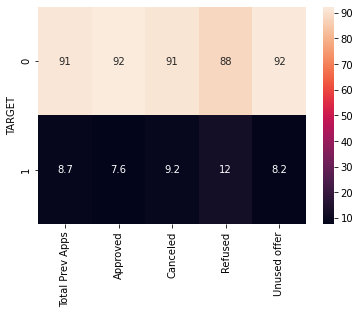

In [84]:
sns.heatmap(df_pa_ca_temp, annot=True)

In [85]:
df_pa_ca_1[df_pa_ca_1['SK_ID_CURR'].isin(ca_ids_wo_pa_ids)][['SK_ID_CURR', 'Total Prev Apps','Approved',	'Canceled',	'Refused',	'Unused offer']]

,SK_ID_CURR,Total Prev Apps,Approved,Canceled,Refused,Unused offer
7,100010,0.0,0.0,0.0,0.0,0.0
10,100014,0.0,0.0,0.0,0.0,0.0
11,100015,0.0,0.0,0.0,0.0,0.0
16,100020,0.0,0.0,0.0,0.0,0.0
20,100024,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
307439,456177,0.0,0.0,0.0,0.0,0.0
307449,456187,0.0,0.0,0.0,0.0,0.0
307450,456188,0.0,0.0,0.0,0.0,0.0
307467,456207,0.0,0.0,0.0,0.0,0.0


In [86]:
df_pa_ca_1['PrevApps'] = df_pa_ca_1['Total Prev Apps'] > 0 

In [87]:
df_pa_ca_1['PA_REFUSED'] = df_pa_ca_1['Refused'] > 0 
df_pa_ca_1['PA_APPROVED'] = df_pa_ca_1['Approved'] > 0 

In [88]:
def getPAStatus(x):
    if  x['Total Prev Apps'] == 0: return "NO_PREV_APPS"
    elif x['Refused'] > 0: return 'REFUSED'
    elif x['Approved'] > 0: return 'APPROVED'
    else: return 'OTHERS'

df_pa_ca_1['PA_STATUS'] = df_pa_ca_1.apply(getPAStatus, axis=1)

In [89]:
df_pa_ca_1[['SK_ID_CURR', 'PA_STATUS', 'PrevApps', 'Total Prev Apps','Approved',	'Canceled',	'Refused',	'Unused offer']]

,SK_ID_CURR,PA_STATUS,PrevApps,Total Prev Apps,Approved,Canceled,Refused,Unused offer
0,100002,APPROVED,True,1.0,1.0,0.0,0.0,0.0
1,100003,APPROVED,True,2.0,2.0,0.0,0.0,0.0
2,100004,APPROVED,True,1.0,1.0,0.0,0.0,0.0
3,100006,APPROVED,True,4.0,3.0,1.0,0.0,0.0
4,100007,APPROVED,True,3.0,3.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
307506,456251,APPROVED,True,1.0,1.0,0.0,0.0,0.0
307507,456252,APPROVED,True,1.0,1.0,0.0,0.0,0.0
307508,456253,APPROVED,True,1.0,1.0,0.0,0.0,0.0
307509,456254,APPROVED,True,2.0,2.0,0.0,0.0,0.0


In [90]:
df_pa_ca_1[df_pa_ca_1['Total Prev Apps']==0][['SK_ID_CURR', 'PA_STATUS', 'PrevApps', 'Total Prev Apps','Approved',	'Canceled',	'Refused',	'Unused offer']]

,SK_ID_CURR,PA_STATUS,PrevApps,Total Prev Apps,Approved,Canceled,Refused,Unused offer
7,100010,NO_PREV_APPS,False,0.0,0.0,0.0,0.0,0.0
10,100014,NO_PREV_APPS,False,0.0,0.0,0.0,0.0,0.0
11,100015,NO_PREV_APPS,False,0.0,0.0,0.0,0.0,0.0
16,100020,NO_PREV_APPS,False,0.0,0.0,0.0,0.0,0.0
20,100024,NO_PREV_APPS,False,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
307439,456177,NO_PREV_APPS,False,0.0,0.0,0.0,0.0,0.0
307449,456187,NO_PREV_APPS,False,0.0,0.0,0.0,0.0,0.0
307450,456188,NO_PREV_APPS,False,0.0,0.0,0.0,0.0,0.0
307467,456207,NO_PREV_APPS,False,0.0,0.0,0.0,0.0,0.0


In [91]:
df_pa_ca_1[df_pa_ca_1['Total Prev Apps']>0]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_YEAR,Total Prev Apps,Approved,Canceled,Refused,Unused offer,PrevApps,PA_REFUSED,PA_APPROVED,PA_STATUS
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,1.0,1.0,1.0,0.0,0.0,0.0,True,False,True,APPROVED
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,2.0,2.0,0.0,0.0,0.0,True,False,True,APPROVED
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,1.0,1.0,0.0,0.0,0.0,True,False,True,APPROVED
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,4.0,3.0,1.0,0.0,0.0,True,False,True,APPROVED
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,3.0,3.0,0.0,0.0,0.0,True,False,True,APPROVED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,NaN,1.0,1.0,0.0,0.0,0.0,True,False,True,APPROVED
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,NaN,1.0,1.0,0.0,0.0,0.0,True,False,True,APPROVED
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,1.0,1.0,1.0,0.0,0.0,0.0,True,False,True,APPROVED
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0.0,2.0,2.0,0.0,0.0,0.0,True,False,True,APPROVED


df_1: 24825, df_0: 282686
           Total  Target=1  Target=0  Target=1%  Target=0%
PrevApps                                                  
False      45180      3406     41774       7.54      92.46
True      262331     21419    240912       8.16      91.84


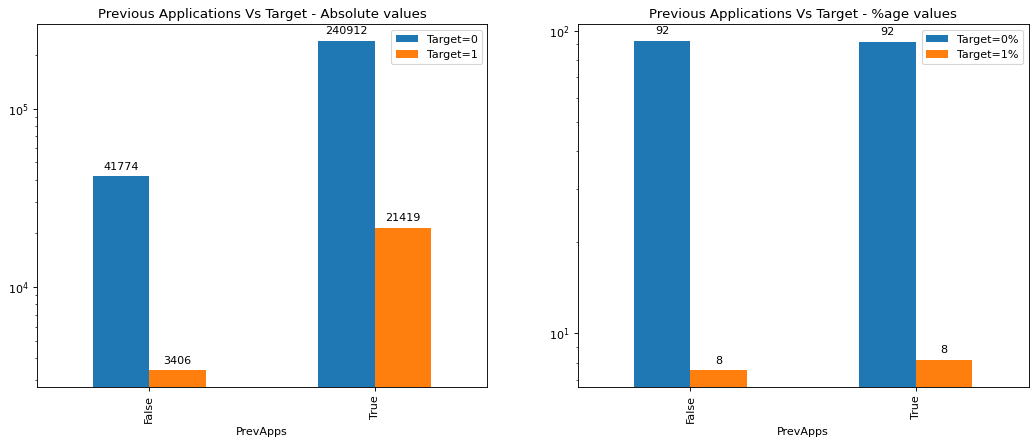

In [92]:
compare(df_pa_ca_1, 'PrevApps', 'Previous Applications', figsize=(16, 6)) 

df_1: 24825, df_0: 282686
               Total  Target=1  Target=0  Target=1%  Target=0%
PA_STATUS                                                     
APPROVED      177282     12524    164758       7.06      92.94
NO_PREV_APPS   45180      3406     41774       7.54      92.46
OTHERS          6030       488      5542       8.09      91.91
REFUSED        79019      8407     70612      10.64      89.36


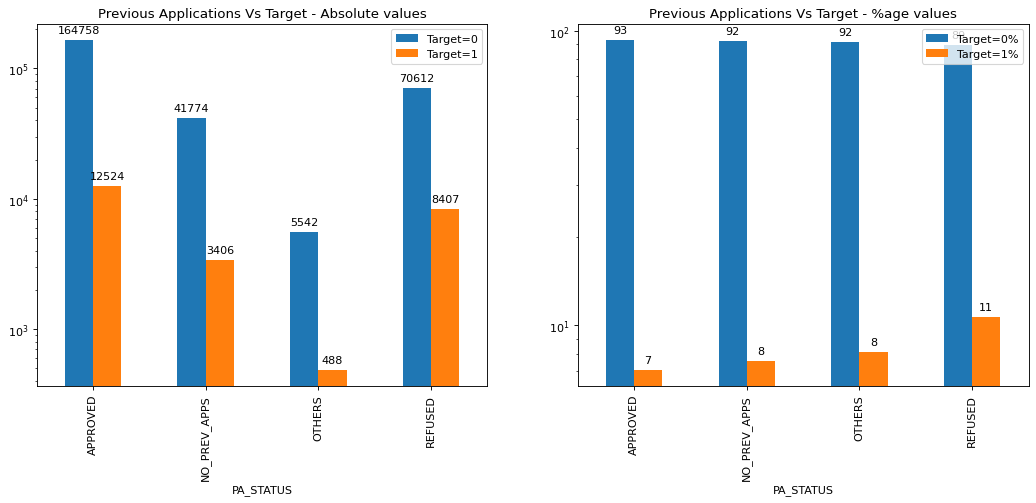

In [93]:
compare(df_pa_ca_1, 'PA_STATUS', 'Previous Applications', figsize=(16, 6)) 

In [94]:
df_pa_ca_target_1 = df_pa_ca_1[df_pa_ca_1['TARGET']==1]
df_pa_ca_target_1

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_YEAR,Total Prev Apps,Approved,Canceled,Refused,Unused offer,PrevApps,PA_REFUSED,PA_APPROVED,PA_STATUS
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,1.0,1.0,1.0,0.0,0.0,0.0,True,False,True,APPROVED
26,100031,1,Cash loans,F,N,Y,0,112500.0,979992.0,27076.5,...,2.0,0.0,0.0,0.0,0.0,0.0,False,False,False,NO_PREV_APPS
40,100047,1,Cash loans,M,N,Y,0,202500.0,1193580.0,35028.0,...,4.0,5.0,4.0,0.0,1.0,0.0,True,True,True,REFUSED
42,100049,1,Cash loans,F,N,N,0,135000.0,288873.0,16258.5,...,2.0,2.0,2.0,0.0,0.0,0.0,True,False,True,APPROVED
81,100096,1,Cash loans,F,N,Y,0,81000.0,252000.0,14593.5,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,NO_PREV_APPS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307448,456186,1,Cash loans,M,N,N,1,207000.0,450000.0,32746.5,...,2.0,2.0,0.0,2.0,0.0,0.0,True,False,False,OTHERS
307475,456215,1,Cash loans,F,N,N,1,144000.0,1303200.0,46809.0,...,6.0,6.0,5.0,0.0,1.0,0.0,True,True,True,REFUSED
307481,456225,1,Cash loans,M,N,Y,0,225000.0,297000.0,19975.5,...,3.0,3.0,1.0,0.0,2.0,0.0,True,True,True,REFUSED
307489,456233,1,Cash loans,F,N,Y,0,225000.0,521280.0,23089.5,...,2.0,1.0,1.0,0.0,0.0,0.0,True,False,True,APPROVED


In [95]:
df_pa_ca_2 = df_ca.merge(df_pa, how='left', on='SK_ID_CURR')
df_pa_ca_2

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0
2,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,Furniture,6.0,middle,POS industry with interest,365243.0,-797.0,-647.0,-647.0,-639.0,0.0
3,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,Connectivity,4.0,middle,POS mobile without interest,365243.0,-784.0,-694.0,-724.0,-714.0,0.0
4,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,XNA,48.0,low_normal,Cash X-Sell: low,365243.0,-151.0,1259.0,-151.0,-143.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932522,456255,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,...,Connectivity,12.0,high,POS mobile with interest,365243.0,-425.0,-95.0,-215.0,-211.0,0.0
932523,456255,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,...,XNA,24.0,middle,Cash X-Sell: middle,365243.0,-662.0,28.0,-212.0,-204.0,1.0
932524,456255,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,...,XNA,24.0,middle,Cash X-Sell: middle,365243.0,-618.0,72.0,-558.0,-528.0,1.0
932525,456255,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,...,Connectivity,0.0,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
df_pa_ca_2['NAME_CONTRACT_STATUS']

0         Approved
1         Approved
2         Approved
3         Approved
4         Approved
            ...   
932522    Approved
932523    Approved
932524    Approved
932525     Refused
932526     Refused
Name: NAME_CONTRACT_STATUS, Length: 932527, dtype: object

In [97]:
groupPerTarget(df_pa_ca_2, 'NAME_CONTRACT_STATUS')

df_1: 80191, df_0: 852336
                       Total  Target=1  Target=0  Target=1%  Target=0%
NAME_CONTRACT_STATUS                                                  
Approved              557533     42313    515220       7.59      92.41
Canceled              161552     14823    146729       9.18      90.82
Refused               153859     18463    135396      12.00      88.00
Unused offer           14403      1186     13217       8.23      91.77


,Total,Target=1,Target=0,Target=1%,Target=0%
NAME_CONTRACT_STATUS,,,,,
Approved,557533,42313,515220,7.59,92.41
Canceled,161552,14823,146729,9.18,90.82
Refused,153859,18463,135396,12.00,88.00
Unused offer,14403,1186,13217,8.23,91.77


df_1: 80191, df_0: 852336
                       Total  Target=1  Target=0  Target=1%  Target=0%
NAME_CONTRACT_STATUS                                                  
Approved              557533     42313    515220       7.59      92.41
Canceled              161552     14823    146729       9.18      90.82
Refused               153859     18463    135396      12.00      88.00
Unused offer           14403      1186     13217       8.23      91.77


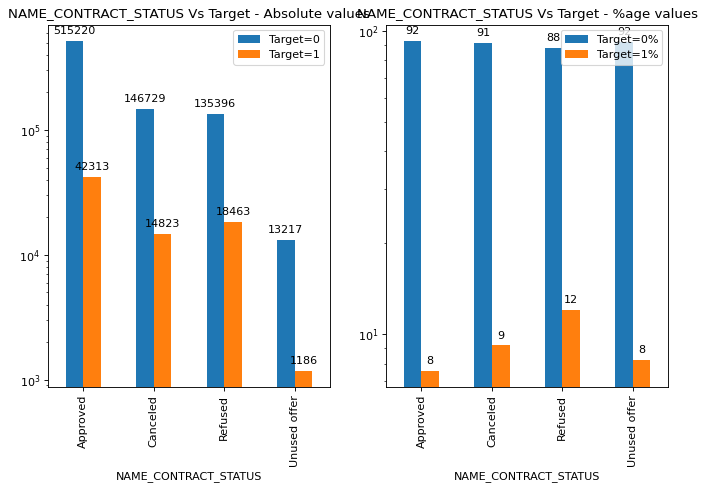

In [98]:
compare(df_pa_ca_2, 'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_STATUS')

In [99]:
df_pa_ca['Refused%'] = round((df_pa_ca['Refused']/df_pa_ca['Total Prev Apps'])*100,2)
df_pa_ca[df_pa_ca['Refused%'] > 50].sort_values(by='Refused%', ascending= False)

,SK_ID_CURR,Total Prev Apps,Approved,Canceled,Refused,Unused offer,Refused%
154398,279969,1,0,0,1,0,100.00
175214,304205,1,0,0,1,0,100.00
175105,304072,1,0,0,1,0,100.00
69963,181530,1,0,0,1,0,100.00
175106,304073,1,0,0,1,0,100.00
...,...,...,...,...,...,...,...
113219,231859,29,7,7,15,0,51.72
37673,143795,29,13,0,15,1,51.72
181715,311791,29,4,9,15,1,51.72
140743,264093,31,5,10,16,0,51.61


In [100]:
print(df_pa.shape[0], df_pa_ca['Total Prev Apps'].sum())

1048575 1048575


In [101]:
curr_ids_rej_pa = df_pa_ca[df_pa_ca['Refused%'] > 75 ]['SK_ID_CURR']
print(curr_ids_rej_pa.shape[0])
curr_ids_rej_pa = curr_ids_rej_pa.tolist()
curr_ids_rej_pa[0:4]

6805


[100030, 100085, 100099, 100205]

In [102]:
# Applications whose previous applications were refused
df_ca[df_ca['SK_ID_CURR'].isin(curr_ids_rej_pa)]#.groupby('TARGET').agg({'TARGET':'count'})

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
25,100030,0,Cash loans,F,N,Y,0,90000.0,225000.0,11074.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
73,100085,0,Cash loans,M,N,Y,1,157500.0,755190.0,28894.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
84,100099,0,Cash loans,F,N,Y,0,360000.0,733315.5,41076.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
176,100205,0,Cash loans,F,N,Y,0,63000.0,808650.0,26217.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
261,100301,1,Cash loans,M,N,Y,1,112500.0,571486.5,31131.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307305,456029,0,Cash loans,F,N,Y,0,81000.0,269550.0,14751.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
307357,456082,0,Cash loans,M,Y,N,0,157500.0,1078200.0,28570.5,...,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
307410,456143,1,Cash loans,F,N,Y,0,85500.0,180000.0,8059.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
307451,456190,0,Cash loans,M,Y,N,1,450000.0,545040.0,25407.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
# 2. Rejected loan application

# 1. Defaulted on several debt payments
# 5. Difficulty getting a job
# 6. Difficulty getting an apartment to rent

In [104]:
# How many current applications have  previous applications?
pa_curr_ids = df_pa['SK_ID_CURR'].unique().tolist(); print(type(pa_curr_ids), len(pa_curr_ids), pa_curr_ids[0:4])
ca_curr_ids = df_ca['SK_ID_CURR'].unique().tolist(); print(type(ca_curr_ids), len(ca_curr_ids), ca_curr_ids[0:4])

curr_ids_with_prev_apps = list(set(pa_curr_ids) & set(ca_curr_ids))
print("Curr ids with prev apps:", type(curr_ids_with_prev_apps), len(curr_ids_with_prev_apps), curr_ids_with_prev_apps[0:4])

curr_ids_wo_prev_apps = set(ca_curr_ids).difference(set(pa_curr_ids))
print("Curr ids w/o prev apps:", type(curr_ids_wo_prev_apps), len(curr_ids_wo_prev_apps), list(curr_ids_wo_prev_apps)[0:4])

print("Verification: ", len(curr_ids_with_prev_apps) + len(curr_ids_wo_prev_apps), len(ca_curr_ids))

<class 'list'> 305828 [271877, 108129, 122040, 176158]
<class 'list'> 307511 [100002, 100003, 100004, 100006]
Curr ids with prev apps: <class 'list'> 262331 [100002, 100003, 100004, 100006]
Curr ids w/o prev apps: <class 'set'> 45180 [393217, 262149, 262151, 131087]
Verification:  307511 307511


#### DAYS_*

In [105]:
# Is a loan still active?
df_pa_date = df_pa[PA_DATE_COLS] # + ['SK_ID_CURR',
print("Shape:",df_pa_date.shape)
print(df_pa_date.info())
print("Numerical values - describe:\n"); print(df_pa_date.describe())
listColumsWithMissingData(df_pa_date)

Shape: (1048575, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   DAYS_FIRST_DRAWING         627867 non-null  float64
 1   DAYS_FIRST_DUE             627867 non-null  float64
 2   DAYS_LAST_DUE_1ST_VERSION  627867 non-null  float64
 3   DAYS_LAST_DUE              627867 non-null  float64
 4   DAYS_TERMINATION           627867 non-null  float64
dtypes: float64(5)
memory usage: 40.0 MB
None
Numerical values - describe:

       DAYS_FIRST_DRAWING  DAYS_FIRST_DUE  DAYS_LAST_DUE_1ST_VERSION  \
count       627867.000000   627867.000000              627867.000000   
mean        342387.346201    13833.802031               33614.930898   
std          88595.441587    72460.126454              106643.960780   
min          -2921.000000    -2892.000000               -2801.000000   
25%         365243.000000    -162

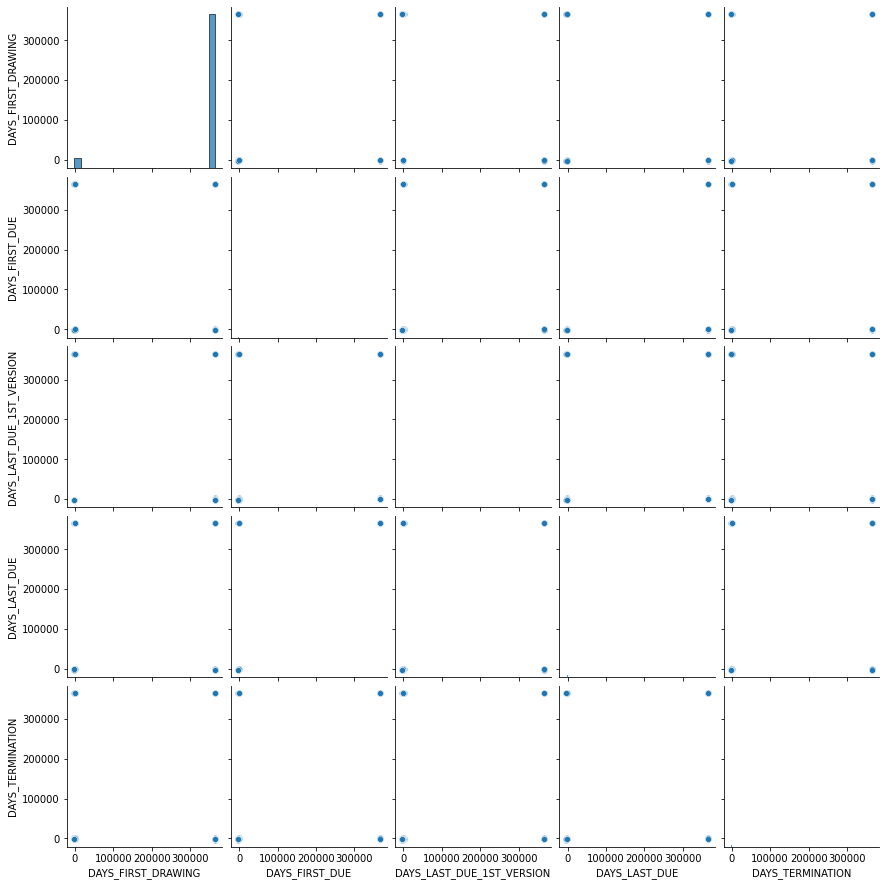

In [106]:
sns.pairplot(data=df_pa_date)

In [107]:
# Where the loan disbursement == termination?
df_pa_date[df_pa_date['DAYS_FIRST_DRAWING'] == df_pa_date['DAYS_TERMINATION']][PA_DATE_COLS]

,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION
1,365243.0,-134.0,916.0,365243.0,365243.0
2,365243.0,-271.0,59.0,365243.0,365243.0
21,365243.0,-656.0,214.0,365243.0,365243.0
44,365243.0,-272.0,-2.0,365243.0,365243.0
58,365243.0,-153.0,-3.0,-3.0,365243.0
...,...,...,...,...,...
1048503,365243.0,-103.0,347.0,365243.0,365243.0
1048515,365243.0,365243.0,365243.0,365243.0,365243.0
1048525,365243.0,-91.0,239.0,365243.0,365243.0
1048545,365243.0,-73.0,257.0,365243.0,365243.0


In [108]:
print(365243/365) # invalid number

1000.6657534246575


In [109]:
df_pa[(df_pa['DAYS_FIRST_DRAWING'].isna()) & (df_pa['DAYS_FIRST_DUE'].isna())
        & (df_pa['DAYS_LAST_DUE_1ST_VERSION'].isna()) & (df_pa['DAYS_LAST_DUE'].isna()) & (df_pa['DAYS_TERMINATION'].isna()) ].shape[0]

420708

In [110]:
df_pa[(~df_pa['DAYS_FIRST_DRAWING'].isna())][['NAME_CONTRACT_STATUS', 'CODE_REJECT_REASON']]

,NAME_CONTRACT_STATUS,CODE_REJECT_REASON
0,Approved,XAP
1,Approved,XAP
2,Approved,XAP
3,Approved,XAP
5,Approved,XAP
...,...,...
1048568,Approved,XAP
1048569,Approved,XAP
1048572,Approved,XAP
1048573,Approved,XAP


In [111]:
df_pa[(~df_pa['DAYS_FIRST_DRAWING'].isna())][['NAME_CONTRACT_STATUS']].value_counts()

NAME_CONTRACT_STATUS
Approved                627867
dtype: int64

In [112]:
df_pa[(df_pa['DAYS_FIRST_DRAWING'].isna())]['NAME_CONTRACT_STATUS'].value_counts()

Canceled        197231
Refused         182083
Approved         24619
Unused offer     16775
Name: NAME_CONTRACT_STATUS, dtype: int64

In [113]:
df_pa[(df_pa['NAME_CONTRACT_STATUS'] == 'Refused')]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
19,1173070,199178,Cash loans,4666.500,45000.0,49455.0,NaN,45000.0,SATURDAY,16,...,XNA,18.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
20,1506815,166490,Cash loans,25454.025,450000.0,491580.0,NaN,450000.0,MONDAY,6,...,XNA,24.0,low_normal,Cash X-Sell: low,NaN,NaN,NaN,NaN,NaN,NaN
22,1172842,302212,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,9,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
23,1172937,302212,Cash loans,39475.305,1129500.0,1277104.5,NaN,1129500.0,THURSDAY,5,...,XNA,54.0,low_normal,Cash X-Sell: low,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048548,2668897,327646,Cash loans,12343.860,202500.0,229230.0,NaN,202500.0,FRIDAY,14,...,XNA,24.0,low_normal,Cash X-Sell: low,NaN,NaN,NaN,NaN,NaN,NaN
1048564,2534927,291054,Revolving loans,22500.000,0.0,450000.0,NaN,NaN,THURSDAY,6,...,XNA,0.0,XNA,Card X-Sell,NaN,NaN,NaN,NaN,NaN,NaN
1048565,2533681,417315,Cash loans,19303.830,292500.0,324162.0,NaN,292500.0,SUNDAY,14,...,XNA,24.0,middle,Cash Street: middle,NaN,NaN,NaN,NaN,NaN,NaN
1048570,2230795,255000,Consumer loans,50978.475,210960.0,189864.0,21096.0,210960.0,SUNDAY,15,...,Industry,4.0,middle,POS other with interest,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
# Where the previous loan is still active?
df_pa[df_pa['DAYS_TERMINATION'] >=0][PA_DATE_COLS]

,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION
1,365243.0,-134.0,916.0,365243.0,365243.0
2,365243.0,-271.0,59.0,365243.0,365243.0
17,-277.0,-257.0,365243.0,365243.0,365243.0
21,365243.0,-656.0,214.0,365243.0,365243.0
34,-265.0,-234.0,365243.0,365243.0,365243.0
...,...,...,...,...,...
1048515,365243.0,365243.0,365243.0,365243.0,365243.0
1048518,-274.0,-225.0,365243.0,365243.0,365243.0
1048525,365243.0,-91.0,239.0,365243.0,365243.0
1048545,365243.0,-73.0,257.0,365243.0,365243.0


In [117]:
round(df_pa[['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']]/365,1)

,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION
0,1000.7,-0.1,0.8,-0.1,-0.1
1,1000.7,-0.4,2.5,1000.7,1000.7
2,1000.7,-0.7,0.2,1000.7,1000.7
3,1000.7,-1.3,-0.4,-0.5,-0.5
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1048570,NaN,NaN,NaN,NaN,NaN
1048571,NaN,NaN,NaN,NaN,NaN
1048572,1000.7,-6.3,-5.7,-5.8,-5.8
1048573,1000.7,-7.8,-7.2,-7.4,-7.2


In [118]:
nacount = df_pa[(df_pa['DAYS_FIRST_DRAWING'].isna())].shape[0] 
nonnacount = df_pa[~(df_pa['DAYS_FIRST_DRAWING'].isna())].shape[0]
print(nacount, nonnacount, nacount+nonnacount,df_pa.shape[0] )

420708 627867 1048575 1048575


#### 3.2 Calls to Credit Bureau

In [119]:
df_ca_character = df_ca[CA_CHARACTER_COLS + ['SK_ID_CURR', 'TARGET']]
print("Shape:",df_ca_character.shape)
print("Numerical values - describe:\n"); print(df_ca_character.describe())
listColumsWithMissingData(df_ca_character)

Shape: (307511, 8)
Numerical values - describe:

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count               265992.000000              265992.000000   
mean                     0.006402                   0.007000   
std                      0.083849                   0.110757   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      4.000000                   9.000000   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count               265992.000000              265992.000000   
mean                     0.034362                   0.267395   
std                      0.204685                   0.916002   
min                      0.000000                   0.000000   
25%                      0.000000                   0.

In [120]:
'''
df_ca_character_nans = df_ca_character[(df_ca_character['AMT_REQ_CREDIT_BUREAU_HOUR'].isna()) & (df_ca_character['AMT_REQ_CREDIT_BUREAU_DAY'].isna())
                        & (df_ca_character['AMT_REQ_CREDIT_BUREAU_WEEK'].isna()) & (df_ca_character['AMT_REQ_CREDIT_BUREAU_MON'].isna())
                        & (df_ca_character['AMT_REQ_CREDIT_BUREAU_QRT'].isna()) & (df_ca_character['AMT_REQ_CREDIT_BUREAU_YEAR'].isna())]
print(df_ca_character_nans.shape[0], df_ca_character.shape[0], percent(df_ca_character_nans.shape[0], df_ca_character.shape[0]))
'''

"\ndf_ca_character_nans = df_ca_character[(df_ca_character['AMT_REQ_CREDIT_BUREAU_HOUR'].isna()) & (df_ca_character['AMT_REQ_CREDIT_BUREAU_DAY'].isna())\n                        & (df_ca_character['AMT_REQ_CREDIT_BUREAU_WEEK'].isna()) & (df_ca_character['AMT_REQ_CREDIT_BUREAU_MON'].isna())\n                        & (df_ca_character['AMT_REQ_CREDIT_BUREAU_QRT'].isna()) & (df_ca_character['AMT_REQ_CREDIT_BUREAU_YEAR'].isna())]\nprint(df_ca_character_nans.shape[0], df_ca_character.shape[0], percent(df_ca_character_nans.shape[0], df_ca_character.shape[0]))\n"

- Add values from all the columns into a single column - gives us the total number of calls in one year before application.
- Either all the columns are filled or non of them are filled (NaN). So we can safelt add the values of all the columns

In [121]:
df_ca_character['ENQUIRIES_CREDIT_BUREAU'] = 0
for col in CA_CHARACTER_COLS:
    df_ca_character['ENQUIRIES_CREDIT_BUREAU'] += df_ca_character[col] 
listColumsWithMissingData(df_ca_character)

Columns with missing data: 7 77.78%
AMT_REQ_CREDIT_BUREAU_HOUR        41519 13.5%
AMT_REQ_CREDIT_BUREAU_DAY         41519 13.5%
AMT_REQ_CREDIT_BUREAU_WEEK        41519 13.5%
AMT_REQ_CREDIT_BUREAU_MON         41519 13.5%
AMT_REQ_CREDIT_BUREAU_QRT         41519 13.5%
AMT_REQ_CREDIT_BUREAU_YEAR        41519 13.5%
ENQUIRIES_CREDIT_BUREAU           41519 13.5%


<AxesSubplot:title={'center':'ENQUIRIES_CREDIT_BUREAU'}, xlabel='TARGET'>

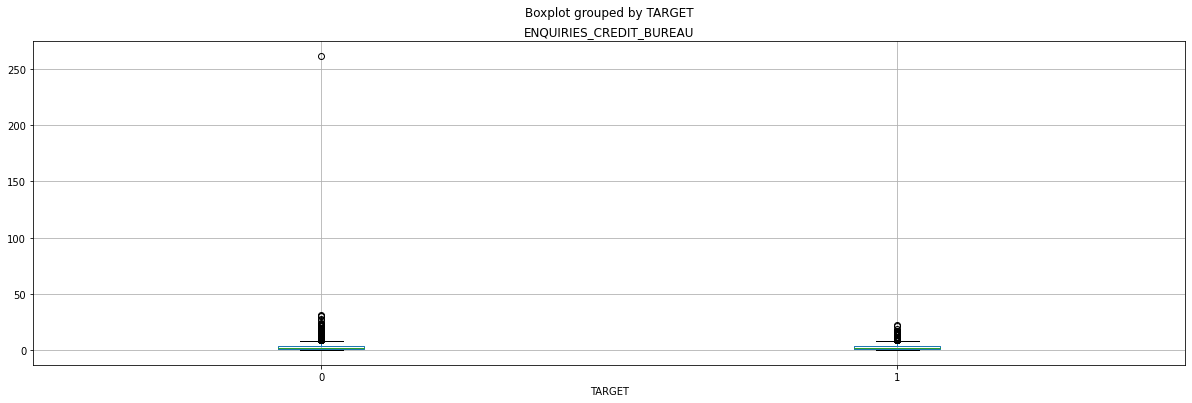

In [122]:
df_ca_character.boxplot(column='ENQUIRIES_CREDIT_BUREAU', by='TARGET', figsize = (20, 6))

In [123]:
df_ca_character = df_ca_character[df_ca_character['ENQUIRIES_CREDIT_BUREAU']!=262]

<AxesSubplot:title={'center':'ENQUIRIES_CREDIT_BUREAU'}, xlabel='TARGET'>

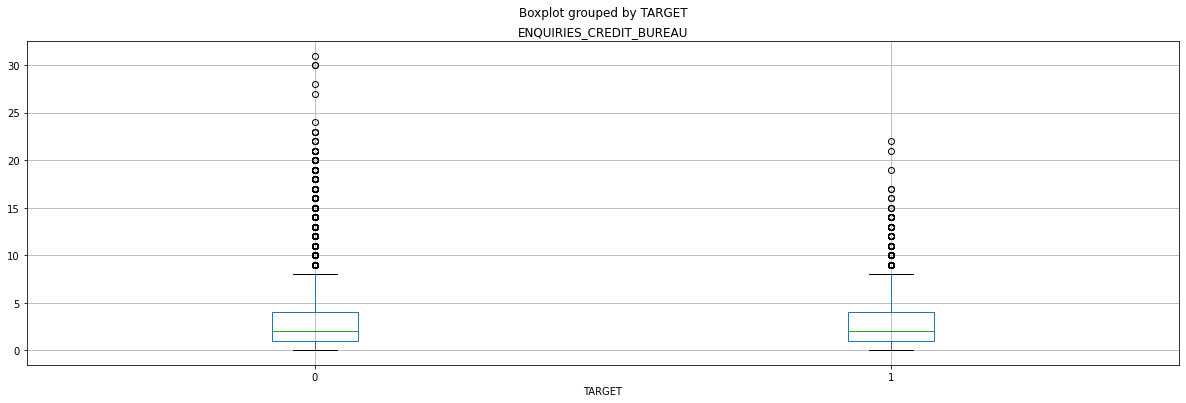

In [124]:
df_ca_character.boxplot(column='ENQUIRIES_CREDIT_BUREAU', by='TARGET', figsize = (20, 6))

df_1: 24825, df_0: 282685
                           Total  Target=1  Target=0  Target=1%  Target=0%
ENQUIRIES_CREDIT_BUREAU                                                   
0.0                      50911.0    3755.0     47156       7.38      92.62
1.0                      53914.0    3997.0     49917       7.41      92.59
2.0                      51559.0    3973.0     47586       7.71      92.29
3.0                      39380.0    3036.0     36344       7.71      92.29
4.0                      27241.0    2160.0     25081       7.93      92.07
5.0                      17248.0    1445.0     15803       8.38      91.62
6.0                      10775.0     883.0      9892       8.19      91.81
7.0                       6428.0     578.0      5850       8.99      91.01
8.0                       3834.0     318.0      3516       8.29      91.71
9.0                       2273.0     217.0      2056       9.55      90.45
10.0                      1055.0      80.0       975       7.58      92.42

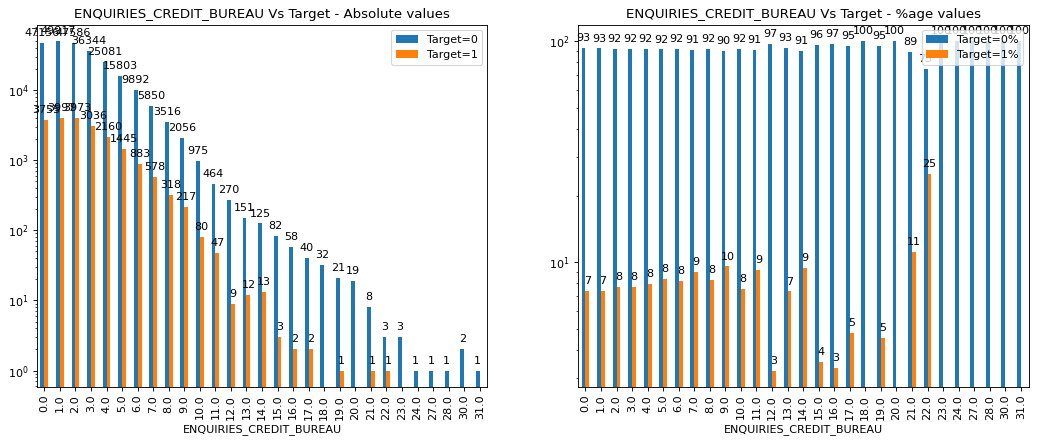

In [125]:
df_ca_character = df_ca_character[['SK_ID_CURR', 'TARGET', 'ENQUIRIES_CREDIT_BUREAU']]
col = 'ENQUIRIES_CREDIT_BUREAU'
df_ = groupPerTarget(df_ca_character, col)
compare(df_ca_character,col, col,figsize=(16, 6))

In [126]:
df_ca_character

,SK_ID_CURR,TARGET,ENQUIRIES_CREDIT_BUREAU
0,100002,1,1.0
1,100003,0,0.0
2,100004,0,0.0
3,100006,0,NaN
4,100007,0,0.0
...,...,...,...
307506,456251,0,NaN
307507,456252,0,NaN
307508,456253,0,3.0
307509,456254,1,0.0


In [127]:
def convertToCategory(x):
    if x == 0: return 'N'
    elif x > 0: return 'Y'
    else: return 'No Information'

df_ca_character['ENQUIRIES_CREDIT_BUREAU_CAT'] = df_ca_character['ENQUIRIES_CREDIT_BUREAU'].apply(convertToCategory)
print("Missing values:"); print(df_ca_character.isna().sum(), percent(df_ca_character.isna().sum(),df_ca_character.shape[0]))
df_ca_character

Missing values:
SK_ID_CURR                         0
TARGET                             0
ENQUIRIES_CREDIT_BUREAU        41519
ENQUIRIES_CREDIT_BUREAU_CAT        0
dtype: int64 SK_ID_CURR                      0.0
TARGET                          0.0
ENQUIRIES_CREDIT_BUREAU        13.5
ENQUIRIES_CREDIT_BUREAU_CAT     0.0
dtype: float64


,SK_ID_CURR,TARGET,ENQUIRIES_CREDIT_BUREAU,ENQUIRIES_CREDIT_BUREAU_CAT
0,100002,1,1.0,Y
1,100003,0,0.0,N
2,100004,0,0.0,N
3,100006,0,NaN,No Information
4,100007,0,0.0,N
...,...,...,...,...
307506,456251,0,NaN,No Information
307507,456252,0,NaN,No Information
307508,456253,0,3.0,Y
307509,456254,1,0.0,N


In [128]:
df_ca_character.groupby(by='ENQUIRIES_CREDIT_BUREAU_CAT').agg({'ENQUIRIES_CREDIT_BUREAU_CAT':'count'})

,ENQUIRIES_CREDIT_BUREAU_CAT
ENQUIRIES_CREDIT_BUREAU_CAT,
N,50911
No Information,41519
Y,215080


df_1: 24825, df_0: 282685
                              Total  Target=1  Target=0  Target=1%  Target=0%
ENQUIRIES_CREDIT_BUREAU_CAT                                                  
N                             50911      3755     47156       7.38      92.62
No Information                41519      4292     37227      10.34      89.66
Y                            215080     16778    198302       7.80      92.20
df_1: 24825, df_0: 282685
                              Total  Target=1  Target=0  Target=1%  Target=0%
ENQUIRIES_CREDIT_BUREAU_CAT                                                  
N                             50911      3755     47156       7.38      92.62
No Information                41519      4292     37227      10.34      89.66
Y                            215080     16778    198302       7.80      92.20


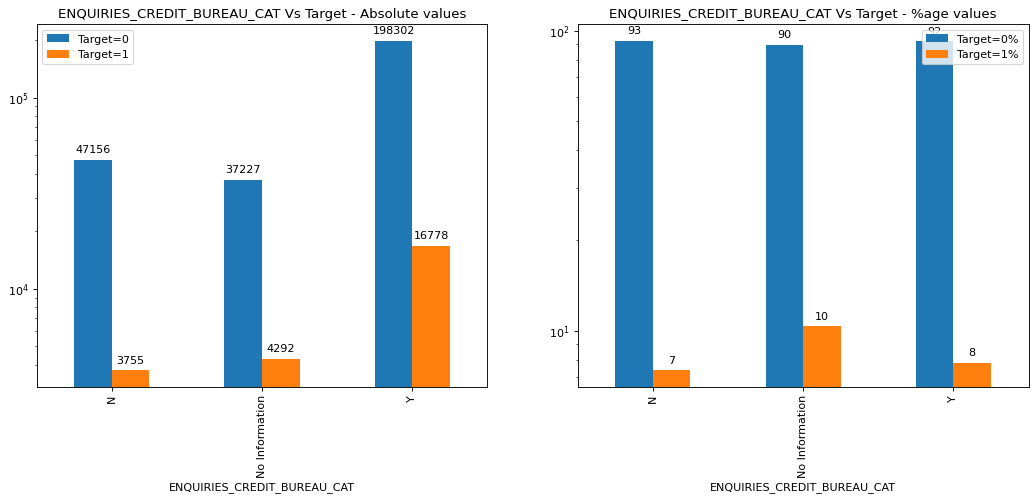

In [129]:
col = 'ENQUIRIES_CREDIT_BUREAU_CAT'
df_ = groupPerTarget(df_ca_character, col)
compare(df_ca_character,col, col,figsize=(16, 6))

In [130]:
df_ca[(df_ca['SK_ID_CURR'].isin(curr_ids_multiple_prev_app))]['TARGET'].value_counts()
round(100. * df_ca['TARGET'].value_counts()/ len(df_ca['TARGET']),2)
df_ca[df_ca['TARGET'] == 1].to_csv("out/defaulter_curr_ids.csv")

#### 3.3 Social circle

In [131]:
df_ca_orig[CA_SOCIAL_CIRCLE_COLS]

,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
0,2.0,2.0,2.0,2.0
1,1.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0
3,2.0,0.0,2.0,0.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
307506,0.0,0.0,0.0,0.0
307507,0.0,0.0,0.0,0.0
307508,6.0,0.0,6.0,0.0
307509,0.0,0.0,0.0,0.0


In [132]:
print(df_ca_orig[CA_SOCIAL_CIRCLE_COLS].mean(), df_ca_orig[CA_SOCIAL_CIRCLE_COLS].median())

OBS_30_CNT_SOCIAL_CIRCLE    1.422245
DEF_30_CNT_SOCIAL_CIRCLE    0.143421
OBS_60_CNT_SOCIAL_CIRCLE    1.405292
DEF_60_CNT_SOCIAL_CIRCLE    0.100049
dtype: float64 OBS_30_CNT_SOCIAL_CIRCLE    0.0
DEF_30_CNT_SOCIAL_CIRCLE    0.0
OBS_60_CNT_SOCIAL_CIRCLE    0.0
DEF_60_CNT_SOCIAL_CIRCLE    0.0
dtype: float64


In [133]:
df_ca_orig[CA_SOCIAL_CIRCLE_COLS].isna().sum()

OBS_30_CNT_SOCIAL_CIRCLE    1021
DEF_30_CNT_SOCIAL_CIRCLE    1021
OBS_60_CNT_SOCIAL_CIRCLE    1021
DEF_60_CNT_SOCIAL_CIRCLE    1021
dtype: int64

In [134]:
df_ca_orig[CA_SOCIAL_CIRCLE_COLS] = df_ca_orig[CA_SOCIAL_CIRCLE_COLS].fillna(0)
df_ca_orig[CA_SOCIAL_CIRCLE_COLS].isna().sum()

OBS_30_CNT_SOCIAL_CIRCLE    0
DEF_30_CNT_SOCIAL_CIRCLE    0
OBS_60_CNT_SOCIAL_CIRCLE    0
DEF_60_CNT_SOCIAL_CIRCLE    0
dtype: int64

In [135]:
df_ca_orig['OBS_CNT_SOCIAL_CIRCLE'] = df_ca_orig['OBS_30_CNT_SOCIAL_CIRCLE'] + df_ca_orig['OBS_60_CNT_SOCIAL_CIRCLE']
df_ca_orig['DEF_CNT_SOCIAL_CIRCLE'] = df_ca_orig['DEF_30_CNT_SOCIAL_CIRCLE'] + df_ca_orig['DEF_60_CNT_SOCIAL_CIRCLE']
df_ca_orig[['OBS_CNT_SOCIAL_CIRCLE','DEF_CNT_SOCIAL_CIRCLE']]
df_ca_orig['DEF_PC_SOCIAL_CIRCLE'] = percent( df_ca_orig['DEF_CNT_SOCIAL_CIRCLE'], df_ca_orig['OBS_CNT_SOCIAL_CIRCLE'])
df_ca_orig['DEF_PC_SOCIAL_CIRCLE'] = df_ca_orig['DEF_PC_SOCIAL_CIRCLE'].fillna(0)
df_ca_orig[['OBS_CNT_SOCIAL_CIRCLE','DEF_CNT_SOCIAL_CIRCLE', 'DEF_PC_SOCIAL_CIRCLE']]

,OBS_CNT_SOCIAL_CIRCLE,DEF_CNT_SOCIAL_CIRCLE,DEF_PC_SOCIAL_CIRCLE
0,4.0,4.0,100.0
1,2.0,0.0,0.0
2,0.0,0.0,0.0
3,4.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
307506,0.0,0.0,0.0
307507,0.0,0.0,0.0
307508,12.0,0.0,0.0
307509,0.0,0.0,0.0


In [136]:
df_ca_def_2 = df_ca_orig[['DEF_PC_SOCIAL_CIRCLE', 'TARGET']]

In [137]:
df_ca_def_2['DEF_PC_SOCIAL_CIRCLE'] = pd.cut(df_ca_def_2['DEF_PC_SOCIAL_CIRCLE'], [-10, 0, 100], labels=['0', '>0'])
df_ca_def_2

,DEF_PC_SOCIAL_CIRCLE,TARGET
0,>0,1
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
307506,0,0
307507,0,0
307508,0,0
307509,0,1


df_1: 24825, df_0: 282686
                       Total  Target=1  Target=0  Target=1%  Target=0%
DEF_PC_SOCIAL_CIRCLE                                                  
0                     272345     21134    251211       7.76      92.24
>0                     35166      3691     31475      10.50      89.50


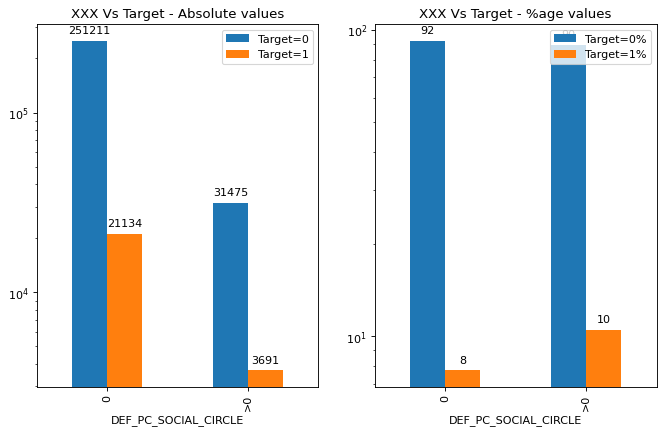

In [138]:
compare(df_ca_def_2, 'DEF_PC_SOCIAL_CIRCLE', 'XXX')

#### **OBSERVATIONS**
| COLUMN(S) | Missing Values? | Outliers? | Observation | Difficulties in paying | No difficulties in paying | 
|---|---|---|---|---|---|
| ENQUIRIES_CREDIT_BUREAU | 13.5% Create a new category "Unknown"| Yes. 262. Can be removed. | Whether there were calls to Credit Bureau does not seem to indicate clients capability to pay loans  |  NA | NA |
| DAYS_* | None | None | TODO: Not clear what these are. Ignore? | TOOD | TOOD |
| PREV_APPS | None | None | Having Prev Apps does not indicate any difficulty or otherwise  | With PrevApps refused | Accountants |
| SOCIAL_CIRCLE_DEFAULT_% | None | None | Clients with defaulters in social circle | Clients with higher percentage of defaulters in social circle  |  Clients with lesser %age of defaulters in social circle |

### 4. Capacity <a class="anchor" id="capacity"></a>
Borrower's ability to repay the loan
- Debt-to-income (DTI) ratio = total monthyl debt/gross monthly income
- DTI < 35% is safe
- Length of time an applicant is employed at their current job

Columns
- INCOME

* [Income](#income)

Borrower's ability to repay the loan
- Current debt
- Income
- Length of time employed at current job

- AMT_INCOME_TOTAL  - numerical, continuous, float

- FLAG_OWN_REALTY == 'Y' does not mean the client is staying there.
- NAME_HOUSING_TYPE indicates the type of housing where the client is staying. Not what he/she owns.

In [169]:
def getGeneralInfo(df):
    print("Shape:",df.shape)
    print(df.info())
    print("Numerical values - describe:\n"); print(df.describe())
    listColumsWithMissingData(df)

In [214]:
CA_AMOUNT_COLS = ['AMT_INCOME_TOTAL', 'AMT_GOODS_PRICE', 'AMT_CREDIT', 'AMT_ANNUITY']
df_ca_capacity = df_ca[CA_AMOUNT_COLS + ['SK_ID_CURR', 'TARGET']]

In [215]:
getGeneralInfo(df_ca_capacity)

Shape: (307511, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   AMT_INCOME_TOTAL  307511 non-null  float64
 1   AMT_GOODS_PRICE   307233 non-null  float64
 2   AMT_CREDIT        307511 non-null  float64
 3   AMT_ANNUITY       307499 non-null  float64
 4   SK_ID_CURR        307511 non-null  int64  
 5   TARGET            307511 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 14.1 MB
None
Numerical values - describe:

       AMT_INCOME_TOTAL  AMT_GOODS_PRICE    AMT_CREDIT    AMT_ANNUITY  \
count      3.075110e+05     3.072330e+05  3.075110e+05  307499.000000   
mean       1.687979e+05     5.383962e+05  5.990260e+05   27108.573909   
std        2.371231e+05     3.694465e+05  4.024908e+05   14493.737315   
min        2.565000e+04     4.050000e+04  4.500000e+04    1615.500000   
25%        1.125000e+05     2.385000

In [216]:
print((df_ca_capacity['AMT_ANNUITY']/df_ca_capacity['AMT_CREDIT']).median())
print((df_ca_capacity['AMT_CREDIT']/df_ca_capacity['AMT_GOODS_PRICE']).median())

0.05
1.1188


- 5% of the Credit amount is the annuity
- 112 % of the goods price is given as credit. 

TODO: We can use this to fill the missing values

- AMT_INCOME_TOTAL - numerical, continuous, float

| COLUMN(S) | Data Type  | Missing? Strateg? | 
|---|---|---|
| AMT_INCOME_TOTAL | Numerical continuous | None | 
| AMT_GOODS_PRICE | Numerical continuous | 112 % of the goods price | 
| AMT_CREDIT | Numerical continuous | None | 
| AMT_ANNUITY | Numerical continuous | 5% of the Credit amount | 


#### Income <a class="anchor" id="income"></a>


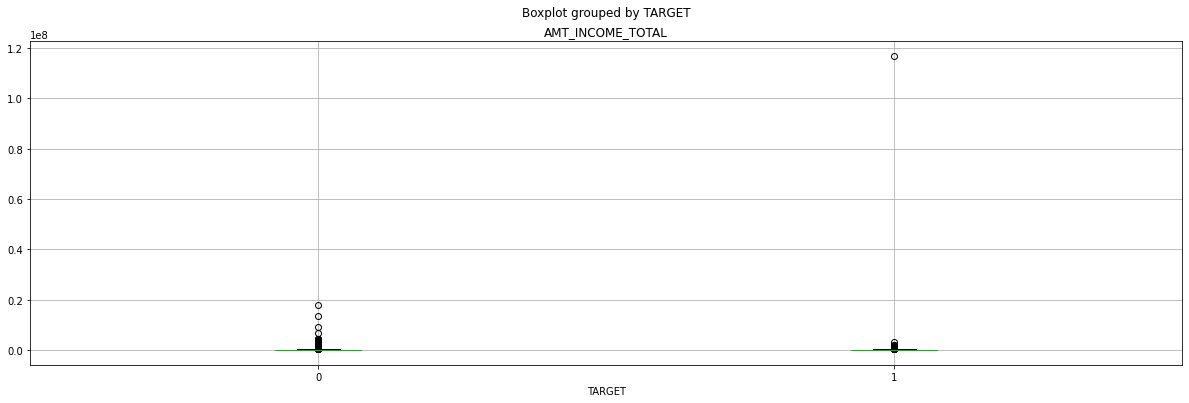

0.9000     270000.0
0.9500     337500.0
0.9999    2250000.0
Name: AMT_INCOME_TOTAL, dtype: float64

In [221]:
df_ca_capacity.boxplot(column='AMT_INCOME_TOTAL', by='TARGET', figsize = (20, 6));plt.show()
df_ca_capacity.quantile([0.9, 0.95, .9999])['AMT_INCOME_TOTAL']

- The boxplot shows that most of the incomes lie in a small range. While a few are extremely high. 
- The spread is very skewed. So bin the income groups
- Are there any particular income groups that struggle to pay back loans? or pay comfortably?

In [223]:
df_ca_maxincome = df_ca.iloc[df_ca['AMT_INCOME_TOTAL'].idxmax()][['SK_ID_CURR','AMT_INCOME_TOTAL'] + CA_CLIENT_COLUMNS ]
df_ca_maxincome[CA_CLIENT_COLUMNS]

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['AGE'], dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [143]:
# - Income and other variables like credit amount
print(df_ca[['AMT_INCOME_TOTAL']].mean(), df_ca[['AMT_INCOME_TOTAL']].median())
print(df_ca[['AMT_INCOME_TOTAL']].quantile([0, 0.00005, 0.0005, 0.005, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99999, 1]))

AMT_INCOME_TOTAL    168797.919297
dtype: float64 AMT_INCOME_TOTAL    147150.0
dtype: float64
         AMT_INCOME_TOTAL
0.00000      2.565000e+04
0.00005      2.700000e+04
0.00050      3.083782e+04
0.00500      4.500000e+04
0.05000      6.750000e+04
0.10000      8.100000e+04
0.25000      1.125000e+05
0.50000      1.471500e+05
0.75000      2.025000e+05
0.90000      2.700000e+05
0.99999      8.831025e+06
1.00000      1.170000e+08


In [202]:
print(df_ca[['AMT_INCOME_TOTAL']].quantile([0, 0.25, 0.5, 0.75, 1])['AMT_INCOME_TOTAL'].to_list())

[25650.0, 112500.0, 147150.0, 202500.0, 117000000.0]


In [144]:
print(getIQR(df_ca,'AMT_INCOME_TOTAL'), getMaxScore(df_ca,'AMT_INCOME_TOTAL'))

90000.0 337500.0


Q1    100576
Q2     53182
Q3     82213
Q4     71538
Name: INCOME_GROUP, dtype: int64
df_1: 24825, df_0: 282686
               Total  Target=1  Target=0  Target=1%  Target=0%
INCOME_GROUP                                                  
Q1            100576      8442     92134       8.39      91.61
Q2             53182      4537     48645       8.53      91.47
Q3             82213      6902     75311       8.40      91.60
Q4             71538      4943     66595       6.91      93.09


<Figure size 800x800 with 0 Axes>

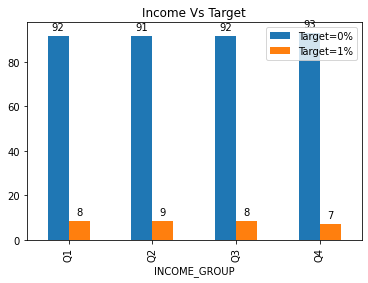

,Total,Target=1,Target=0,Target=1%,Target=0%
INCOME_GROUP,,,,,
Q1,100576,8442,92134,8.39,91.61
Q2,53182,4537,48645,8.53,91.47
Q3,82213,6902,75311,8.40,91.60
Q4,71538,4943,66595,6.91,93.09


In [204]:
# Bin the AMT_INCOME_TOTAL into smaller groups
df_ca_copy_1 = df_ca.copy()
df_ca_copy_1['INCOME_GROUP'] = pd.cut(df_ca_copy_1['AMT_INCOME_TOTAL'], df_ca[['AMT_INCOME_TOTAL']].quantile([0, 0.25, 0.5, 0.75, 1])['AMT_INCOME_TOTAL'].to_list(), labels=['Q1', 'Q2', 'Q3', 'Q4',])
income_groups = df_ca_copy_1['INCOME_GROUP'].value_counts(sort=False)
print(income_groups)
#plotBar(income_groups,"Income Groups", w=8, h=4, logy=True)

# Group the income bins based on TARGET
df_ca_copy_income_1 = groupPerTarget(df_ca_copy_1, 'INCOME_GROUP')
plotBar(df_ca_copy_income_1[['Target=0%','Target=1%']], "Income Vs Target")

df_ca_copy_income_1

<50K      4517
<1L      59181
<10L    243563
<50L       245
>50L         5
Name: INCOME_GROUP, dtype: int64
df_1: 24825, df_0: 282686
               Total  Target=1  Target=0  Target=1%  Target=0%
INCOME_GROUP                                                  
<50K            4517       343      4174       7.59      92.41
<1L            59181      4882     54299       8.25      91.75
<10L          243563     19587    223976       8.04      91.96
<50L             245        12       233       4.90      95.10
>50L               5         1         4      20.00      80.00


<Figure size 800x800 with 0 Axes>

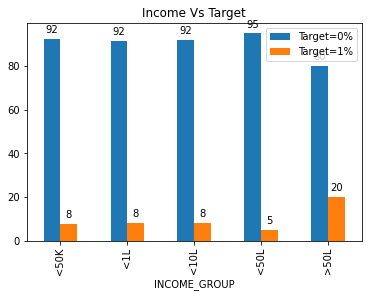

,Total,Target=1,Target=0,Target=1%,Target=0%
INCOME_GROUP,,,,,
<50K,4517,343,4174,7.59,92.41
<1L,59181,4882,54299,8.25,91.75
<10L,243563,19587,223976,8.04,91.96
<50L,245,12,233,4.90,95.10
>50L,5,1,4,20.00,80.00


In [205]:
# Bin the AMT_INCOME_TOTAL into smaller groups
df_ca_copy = df_ca.copy()
df_ca_copy['INCOME_GROUP'] = pd.cut(df_ca_copy['AMT_INCOME_TOTAL'], [0, 50000, 100000, 1000000, 5000000, 200000000], labels=['<50K', '<1L', '<10L', '<50L', '>50L'])
income_groups = df_ca_copy['INCOME_GROUP'].value_counts(sort=False)
print(income_groups)
#plotBar(income_groups,"Income Groups", w=8, h=4, logy=True)

# Group the income bins based on TARGET
df_ca_copy_income = groupPerTarget(df_ca_copy, 'INCOME_GROUP')
plotBar(df_ca_copy_income[['Target=0%','Target=1%']], "Income Vs Target")

df_ca_copy_income

# TODO: 
# - Add % in the annotation
# - Plot according to quartile and check

In [ ]:
.quantile([0, 0.00005, 0.0005, 0.005, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99999, 1]

In [146]:
df_ca.iloc[df_ca['AMT_INCOME_TOTAL'].idxmax()][['SK_ID_CURR','AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE']] # + CA_CLIENT_COLUMNS ]

SK_ID_CURR               114967
AMT_INCOME_TOTAL    117000000.0
AMT_CREDIT             562491.0
AMT_GOODS_PRICE        454500.0
Name: 12840, dtype: object

In [147]:
df_ca_max_income = df_ca[df_ca['SK_ID_CURR'] < 114967]
id, income, credit, goods_price = df_ca.iloc[df_ca['AMT_INCOME_TOTAL'].idxmax()][['SK_ID_CURR','AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE']].to_list()
print(id, income, credit, goods_price, round(100 * credit/income,2))
print(100 * df_ca_max_income['AMT_CREDIT']/df_ca_max_income['AMT_INCOME_TOTAL'])

114967 117000000.0 562491.0 454500.0 0.48
0        200.788889
1        479.075000
2        200.000000
3        231.616667
4        422.222222
            ...    
12835    500.000000
12836    276.866667
12837    159.733333
12838    427.482353
12839    175.573333
Length: 12840, dtype: float64


Max income value is 11 crores. Goods price is 4.5L and credit value is 5.6 L. The loan amount is < 1% of the income which seems bizzare. This can be removed.

In [148]:
df_ca_red = df_ca[df_ca['AMT_INCOME_TOTAL'] < getMaxScore(df_ca,'AMT_INCOME_TOTAL')]
print(df_ca.shape[0], df_ca_red.shape[0])

307511 291686


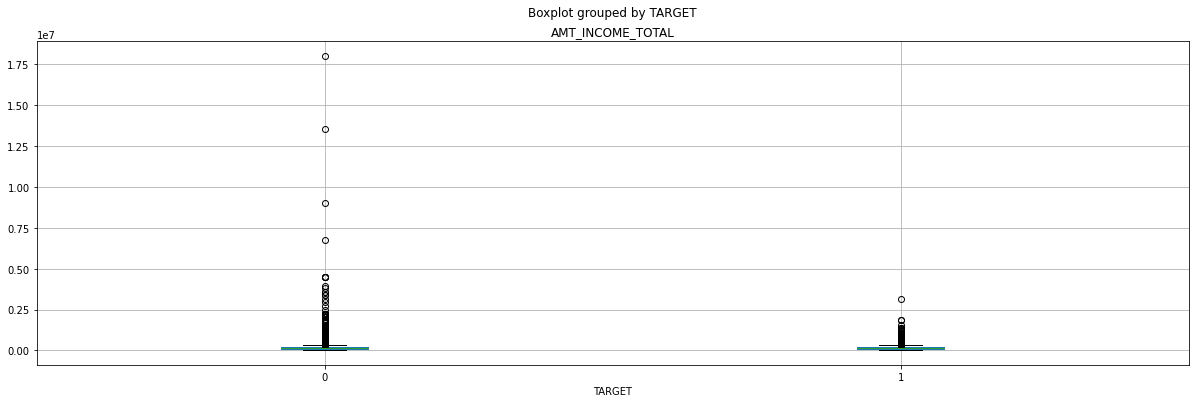

In [210]:
# Outliers - box plot
df_ca_red.boxplot(column='AMT_INCOME_TOTAL', by='TARGET', figsize = (20, 6)); plt.show()

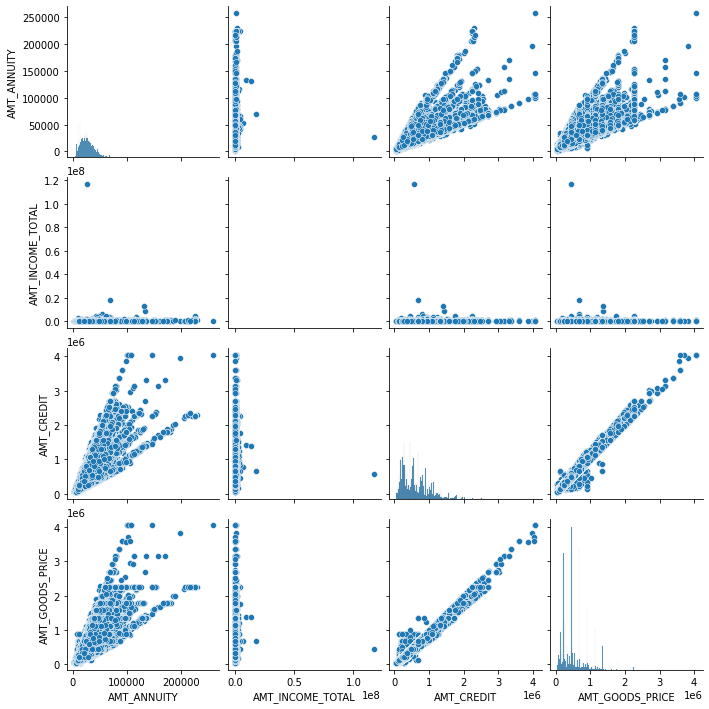

In [208]:
sns.pairplot(data=df_ca_capacity[CA_AMOUNT_COLS])

Correlations exist between
- AMT_CREDIT, AMT_GOODS_PRICE - Strong +ve 
- AMT_ANNITY & MT_CREDIT, AMT_GOODS_PRICE - Strong +ve 
- 

- How much is the annuity (wrt to the loan amount)? 
- How much is the loan amount (wrt the goods price) is normally given?

In [187]:
print(df_ca_capacity[df_ca_capacity['AMT_ANNUITY'] < df_ca_capacity['AMT_CREDIT']/12].shape[0]/df_ca_capacity.shape[0])
print(df_ca_capacity[df_ca_capacity['AMT_ANNUITY'] > df_ca_capacity['AMT_CREDIT']/12].shape[0]/df_ca_capacity.shape[0])

print(df_ca_capacity[df_ca_capacity['AMT_GOODS_PRICE']==df_ca_capacity['AMT_CREDIT']].shape[0]/df_ca_capacity.shape[0])
print(df_ca_capacity[df_ca_capacity['AMT_GOODS_PRICE'] > df_ca_capacity['AMT_CREDIT']].shape[0]/df_ca_capacity.shape[0])
print(df_ca_capacity[df_ca_capacity['AMT_GOODS_PRICE'] < df_ca_capacity['AMT_CREDIT']].shape[0]/df_ca_capacity.shape[0])

0.35188985109475757
0.0008454982098201365
0.646360617994153


#### DEBT_TO_INCOME

In [163]:
df_ca['DEBT_TO_INCOME'] = percent(df_ca['AMT_ANNUITY'], df_ca['AMT_INCOME_TOTAL'])
print(df_ca[(df_ca['DEBT_TO_INCOME'] > 35) & (df_ca['TARGET'] == 1) ][['DEBT_TO_INCOME', 'TARGET']])
print(df_ca[(df_ca['DEBT_TO_INCOME'] > 35) & (df_ca['TARGET'] == 0) ][['DEBT_TO_INCOME', 'TARGET']])

        DEBT_TO_INCOME  TARGET
235              42.07       1
260              35.66       1
678             137.39       1
782              39.42       1
1113             38.68       1
...                ...     ...
306265           40.28       1
306306           45.96       1
306619           47.31       1
306631           77.76       1
307363           73.57       1

[1329 rows x 2 columns]
        DEBT_TO_INCOME  TARGET
35               39.56       0
43               39.79       0
54               40.09       0
60               48.33       0
112              36.35       0
...                ...     ...
307462           42.39       0
307464           46.36       0
307476           35.89       0
307480           48.73       0
307491           35.02       0

[15175 rows x 2 columns]


<AxesSubplot:title={'center':'DEBT_TO_INCOME'}, xlabel='TARGET'>

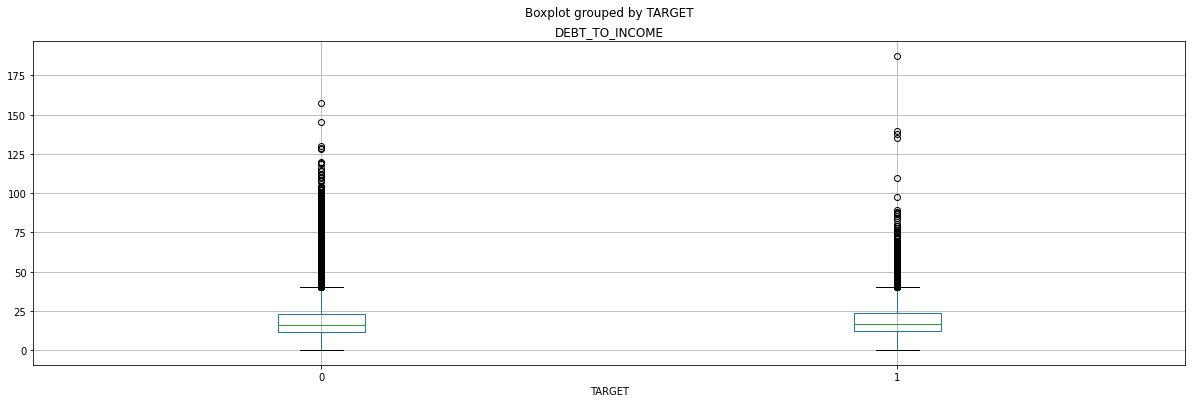

In [162]:
df_ca.boxplot(column='DEBT_TO_INCOME', by='TARGET', figsize = (20, 6))

#### Income, Credit, Goods

In [150]:
df_ca.iloc[df_ca['AMT_INCOME_TOTAL'].idxmax()][['SK_ID_CURR','AMT_INCOME_TOTAL']]

SK_ID_CURR               114967
AMT_INCOME_TOTAL    117000000.0
Name: 12840, dtype: object

In [151]:
df_ca_red = df_ca[df_ca['SK_ID_CURR'] != 114967]
print(df_ca.shape[0], df_ca_red.shape[0])

307511 307510


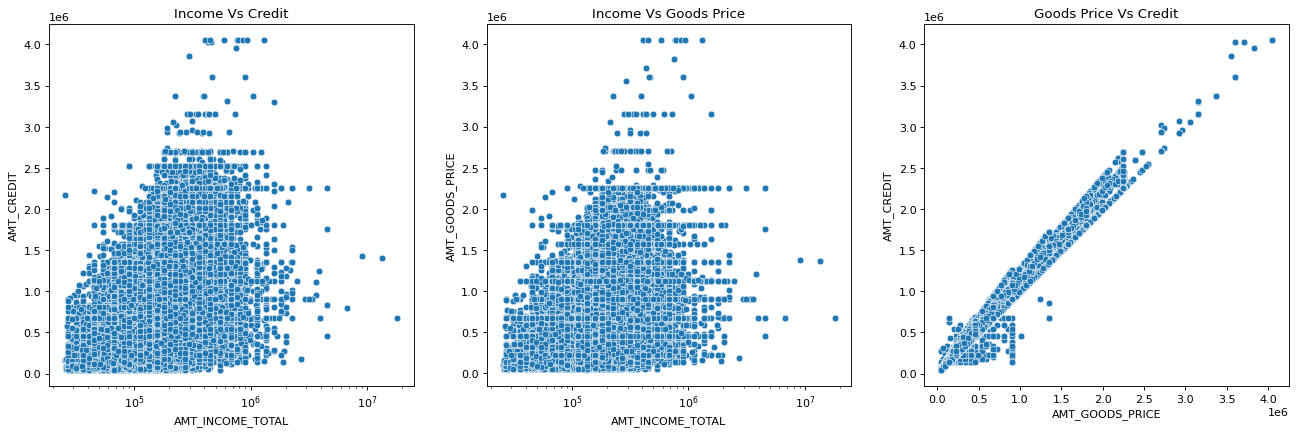

In [152]:
plt.figure(figsize=(20, 6), dpi=80)
plt.subplot(1, 3, 1)
ax = sns.scatterplot(df_ca_red['AMT_INCOME_TOTAL'], df_ca_red['AMT_CREDIT']); ax.set_xscale('log'); ax.set_title("Income Vs Credit")
plt.subplot(1, 3, 2)
ax = sns.scatterplot(df_ca_red['AMT_INCOME_TOTAL'], df_ca_red['AMT_GOODS_PRICE']); ax.set_xscale('log'); ax.set_title("Income Vs Goods Price")
plt.subplot(1, 3, 3)
ax = sns.scatterplot(df_ca_red['AMT_GOODS_PRICE'], df_ca_red['AMT_CREDIT']); ax.set_title("Goods Price Vs Credit")
plt.show()

# TODO: How to get the outliers? 

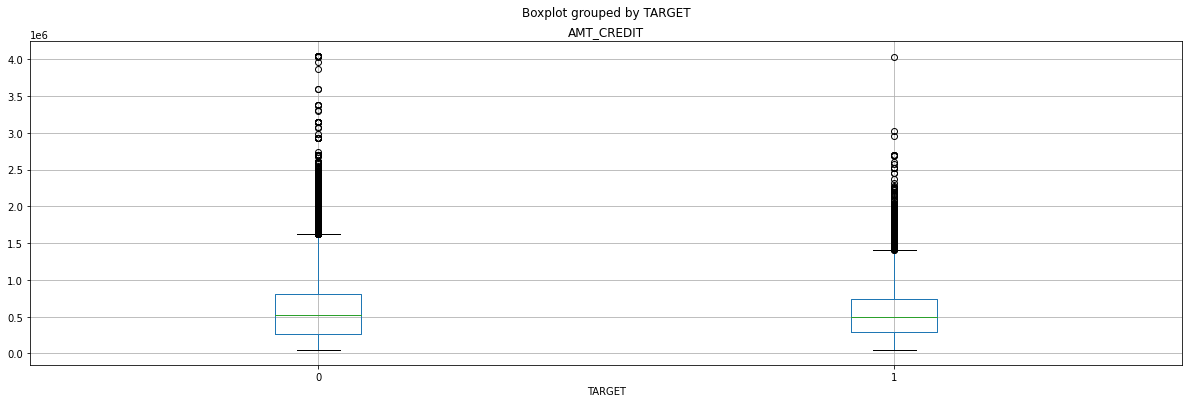

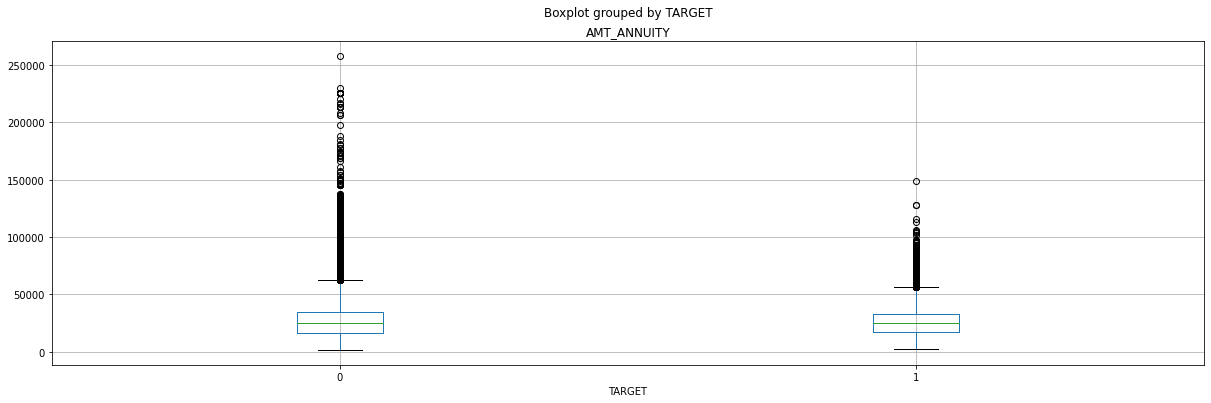

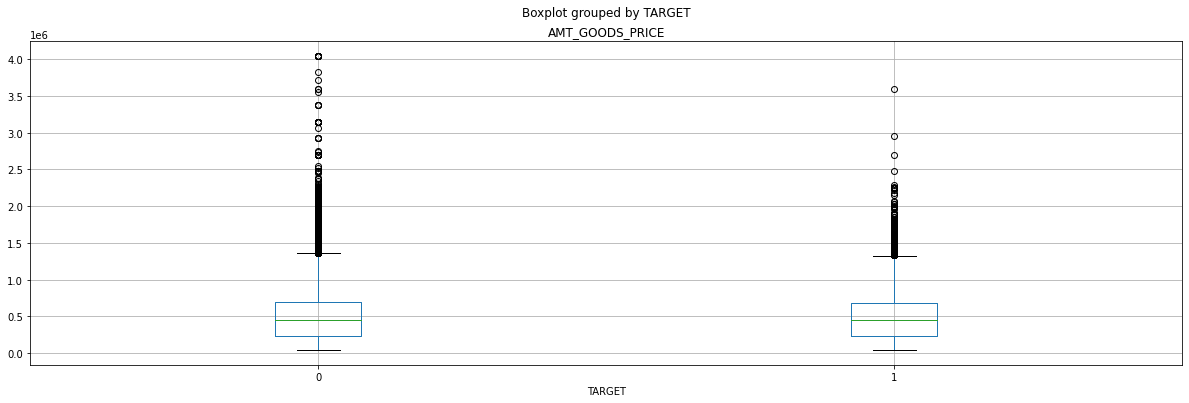

In [153]:
for col in ['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']:
    df_ca.boxplot(column=col, by='TARGET', figsize = (20, 6))

#### **OBSERVATIONS**
| COLUMN(S) | Missing Values? | Outliers? | Observation | Difficulties in paying | No difficulties in paying | 
|---|---|---|---|---|---|
| DEBT-TO-INCOME |  |  |  |  |  |
| 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE' | None| NA | Independently these does not affect the client's ability to pay |  |  |
| INCOME | None | 11 cr | None | >50L | None |

### 5. Capital
- Down payment indicates borrower's level of seriousness
- Downpayment size
- Overall wealth that borrower possess - Car, Realty
* [Realty & Car](#realty-car)
COLUMNS
- FLAG_OWN_CAR      - categorical
- FLAG_OWN_REALTY   - categorical

#### FLAG_OWN_REALTY, FLAG_OWN_CAR

In [154]:
print(df_ca[df_ca['FLAG_OWN_REALTY'] == 'Y'][['SK_ID_CURR','NAME_HOUSING_TYPE']].sort_values(by='NAME_HOUSING_TYPE', ascending=False))
print(df_ca[ (df_ca['FLAG_OWN_REALTY'] == 'N') & (~ df_ca['NAME_HOUSING_TYPE'].isna()) ][['SK_ID_CURR','FLAG_OWN_REALTY', 'NAME_HOUSING_TYPE']])

        SK_ID_CURR NAME_HOUSING_TYPE
109770      227307      With parents
187636      317517      With parents
35122       140686      With parents
253378      393196      With parents
35128       140692      With parents
...            ...               ...
11779       113727   Co-op apartment
287090      432533   Co-op apartment
162552      288444   Co-op apartment
137125      259040   Co-op apartment
84930       198531   Co-op apartment

[213312 rows x 2 columns]
        SK_ID_CURR FLAG_OWN_REALTY  NAME_HOUSING_TYPE
1           100003               N  House / apartment
13          100017               N  House / apartment
16          100020               N  House / apartment
22          100026               N   Rented apartment
24          100029               N  House / apartment
...            ...             ...                ...
307494      456238               N  House / apartment
307495      456239               N  House / apartment
307496      456240               N  House /

df_1: 24825, df_0: 282686
               Total  Target=1  Target=0  Target=1%  Target=0%
FLAG_OWN_CAR                                                  
N             202924     17249    185675       8.50      91.50
Y             104587      7576     97011       7.24      92.76
df_1: 24825, df_0: 282686
                  Total  Target=1  Target=0  Target=1%  Target=0%
FLAG_OWN_REALTY                                                  
N                 94199      7842     86357       8.32      91.68
Y                213312     16983    196329       7.96      92.04


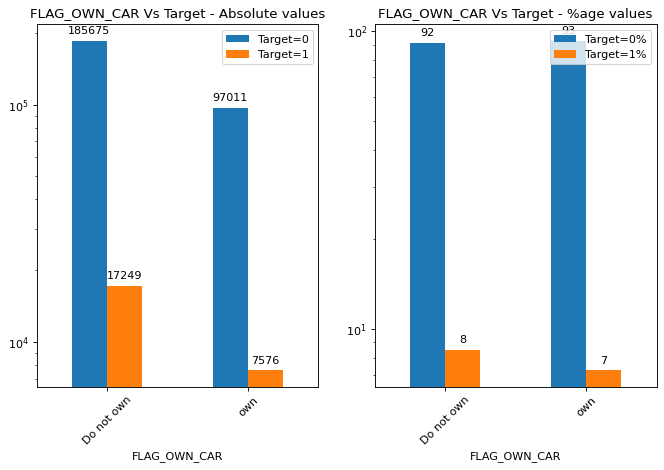

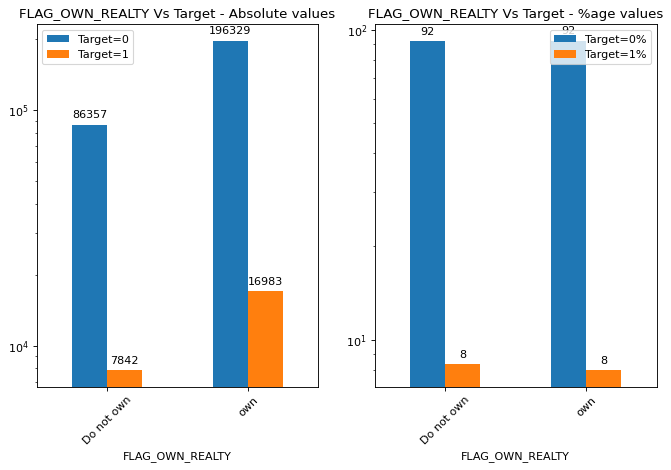

In [155]:
for col in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df_= compare(df_ca, col, col, labels =["Do not own", "own"])

In [156]:
print(df_ca[df_ca['DAYS_EMPLOYED'] > 0][['DAYS_EMPLOYED']].value_counts())
print(df_ca[df_ca['DAYS_EMPLOYED'] > 0][['TARGET']].value_counts())
df_ca[df_ca['DAYS_EMPLOYED'] < 0][['DAYS_EMPLOYED','TARGET']]

DAYS_EMPLOYED
365243           55374
dtype: int64
TARGET
0         52384
1          2990
dtype: int64


,DAYS_EMPLOYED,TARGET
0,-637,1
1,-1188,0
2,-225,0
3,-3039,0
4,-3038,0
...,...,...
307504,-7258,0
307506,-236,0
307508,-7921,0
307509,-4786,1


#### Application

In [157]:
df_ca[['SK_ID_CURR'] + CA_APPLICATION_COLUMNS]

import functools
df_ca['FLAG_DOCUMENT'] = functools.reduce(lambda a, b: a+b, [df_ca[col] for col in CA_FLAG_DOCUMENT_COLUMNS])
df_ca[['SK_ID_CURR', 'FLAG_DOCUMENT'] + CA_FLAG_DOCUMENT_COLUMNS]
df_ca['FLAG_DOCUMENT'].describe()
df_ca['FLAG_DOCUMENT'].value_counts()
df_ca[df_ca['FLAG_DOCUMENT']==4]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DEBT_TO_INCOME,FLAG_DOCUMENT
92114,206962,1,Cash loans,M,N,N,1,180000.0,1006920.0,38484.0,...,1,1,0.0,0.0,0.0,0.0,0.0,0.0,21.38,4


In [158]:
df_ca[df_ca['FLAG_DOCUMENT']==4]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DEBT_TO_INCOME,FLAG_DOCUMENT
92114,206962,1,Cash loans,M,N,N,1,180000.0,1006920.0,38484.0,...,1,1,0.0,0.0,0.0,0.0,0.0,0.0,21.38,4


#### OBSERVATIONS


## Data Exploration - Previous Application

## Data Standardisation
- Remove decimals from the amounts
- Convert age to years & months - not days
- Convert amounts to K or L? 
- Convert numeric flags to categorical values

## Correlation 

In [159]:
df_ca.columns.tolist()[:50]

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'FLAG_DOCUMENT_2'

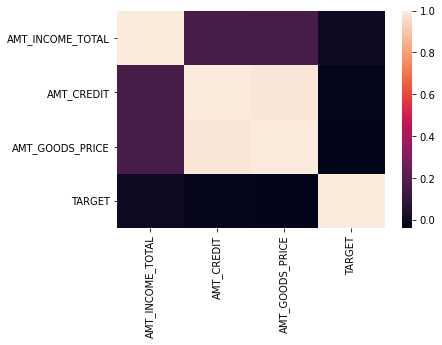

In [160]:
sns.heatmap(df_ca[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_GOODS_PRICE','TARGET']].corr());plt.show()

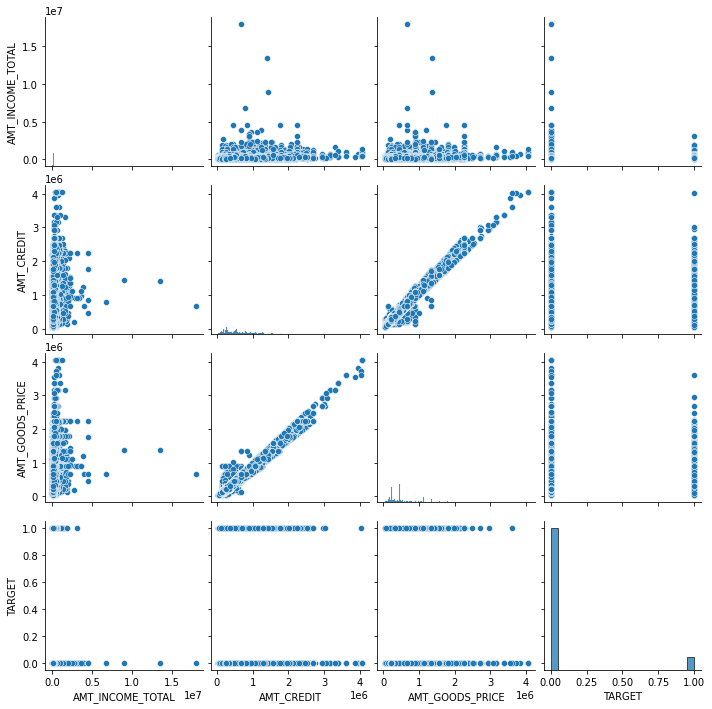

In [161]:
sns.pairplot(data=df_ca_red[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_GOODS_PRICE','TARGET']])